# Data analyse ville de Sète

## 0) Setup


In [1]:
from __future__ import annotations

import os
from pathlib import Path
import re

MPLCONFIGDIR = Path(os.environ.get("MPLCONFIGDIR", Path.cwd() / ".mplconfig"))
MPLCONFIGDIR.mkdir(parents=True, exist_ok=True)
os.environ["MPLCONFIGDIR"] = str(MPLCONFIGDIR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

COLOR_PRIMARY = "#0000B9"
COLOR_SECONDARY = "#FF4500"
COLOR_ACCENT = "#CAF700"
COLOR_PALETTE = [COLOR_PRIMARY, COLOR_SECONDARY, COLOR_ACCENT]

PLOT_BG = "#f5f5f2"

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=COLOR_PALETTE)
plt.rcParams["axes.facecolor"] = PLOT_BG
plt.rcParams["figure.facecolor"] = PLOT_BG
plt.rcParams["savefig.facecolor"] = PLOT_BG
plt.rcParams["font.family"] = "Avenir"
plt.rcParams.update({
    "font.family": "Avenir",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

pd.set_option("display.max_columns", 60)
pd.set_option("display.width", 140)

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
DATA_DIR = PROJECT_ROOT / "data"
INTERIM_DIR = DATA_DIR / "interim"

CONFIG = {
    "commune_code": "34301",
    "mapping_path": DATA_DIR / "mapping_candidats_blocs.csv",
    "focus_type": "legislatives",
    "focus_tour": 1,
    "focus_year": 2022,
    "base_type": "municipales",
    "base_tour": 1,
    "constant_perimeter": False,
    "constant_perimeter_type": "municipales",
    "constant_perimeter_tour": 1,
    "save_interim": True,
    "nuance_type_filter": None,
}

COMMUNE_CODE = CONFIG["commune_code"]

ELECTIONS_LONG_PATH = INTERIM_DIR / "elections_long.parquet"
if not ELECTIONS_LONG_PATH.exists():
    raise FileNotFoundError(f"Fichier manquant: {ELECTIONS_LONG_PATH}")


FIG_DIR = PROJECT_ROOT / "output" / "rapport_final"
FIG_DIR.mkdir(parents=True, exist_ok=True)
SAVE_FIGS = True

def save_fig(name: str) -> None:
    # Save figures in a dedicated folder, per report requirement
    if not SAVE_FIGS:
        return
    path = FIG_DIR / f"{name}.png"
    plt.savefig(path, dpi=150, bbox_inches="tight")
    print(f"Saved: {path}")


## 1) Chargement & controles de base


In [2]:
elections_long = pd.read_parquet(ELECTIONS_LONG_PATH)

elections_long["code_bv"] = elections_long["code_bv"].astype(str).str.zfill(9)
if "code_commune" not in elections_long.columns:
    elections_long["code_commune"] = elections_long["code_bv"].str.slice(0, 5)
elections_long["code_commune"] = elections_long["code_commune"].astype(str).str.zfill(5)
elections_long["bureau"] = elections_long["code_bv"].str[-4:]

elections_long["date_scrutin"] = pd.to_datetime(elections_long["date_scrutin"], errors="coerce")

for col in ["inscrits", "votants", "exprimes", "abstentions", "blancs", "nuls"]:
    if col not in elections_long.columns:
        elections_long[col] = np.nan
    elections_long[col] = pd.to_numeric(elections_long[col], errors="coerce")

elections_long["abstentions"] = elections_long["abstentions"].fillna(
    elections_long["inscrits"] - elections_long["votants"]
)

elections_sete = elections_long[elections_long["code_commune"] == COMMUNE_CODE].copy()


def check_totals_consistency(df: pd.DataFrame, key_cols: list[str]) -> None:
    tot_cols = ["inscrits", "votants", "exprimes", "blancs", "nuls", "abstentions"]
    present = [c for c in tot_cols if c in df.columns]
    nun = df.groupby(key_cols)[present].nunique(dropna=False)
    bad = nun[(nun > 1).any(axis=1)]
    if len(bad):
        raise ValueError(f"Incoherences totaux sur {len(bad)} groupes (ex: {bad.index[0]})")


check_totals_consistency(elections_sete, ["code_bv", "date_scrutin", "type_scrutin", "tour"])

neg = (elections_sete["abstentions"] < 0).sum()
assert neg == 0, f"abstentions negatives: {neg}"

print("elections_sete.shape", elections_sete.shape)

events = (
    elections_sete[["date_scrutin", "type_scrutin", "tour", "annee"]]
    .drop_duplicates()
    .sort_values(["date_scrutin", "type_scrutin", "tour"])
)
events


elections_sete.shape (1619, 889)


date_scrutin     type_scrutin  tour  annee
26990   2014-03-23      municipales     1   2014
29584   2014-03-23      municipales     2   2014
18900   2014-05-25      europeennes     1   2014
32439   2017-04-23  presidentielles     1   2017
33351   2017-05-07  presidentielles     2   2017
30615   2017-06-11     legislatives     1   2017
31527   2017-06-18     legislatives     2   2017
34265   2019-05-26      europeennes     1   2019
35182   2020-03-15      municipales     1   2020
35632   2020-06-28      municipales     2   2020
36493   2021-06-20  departementales     1   2021
38341   2021-06-20       regionales     1   2021
37417   2021-06-27  departementales     2   2021
39265   2021-06-27       regionales     2   2021
42089   2022-04-10  presidentielles     1   2022
43032   2022-04-24  presidentielles     2   2022
40203   2022-06-12     legislatives     1   2022
41146   2022-06-19     legislatives     2   2022
45758   2024-06-09      europeennes     1   2024
43997   2024-06-30     legislatives     1   2024

## 2) Analyse de la ville (INSEE)


In [3]:
SOCIO_2014_PATH = DATA_DIR / "sociodemo" / "pop-2014.csv"
SOCIO_2021_PATH = DATA_DIR / "sociodemo" / "pop-2021.csv"

socio14 = pd.read_csv(SOCIO_2014_PATH, sep=";", low_memory=False)
socio21 = pd.read_csv(SOCIO_2021_PATH, sep=";", low_memory=False)

socio14["Commune ou ARM"] = socio14["Commune ou ARM"].astype(str).str.zfill(5)
socio21["COM"] = socio21["COM"].astype(str).str.zfill(5)

socio14_sete = socio14[socio14["Commune ou ARM"] == COMMUNE_CODE].copy()
socio21_sete = socio21[socio21["COM"] == COMMUNE_CODE].copy()

print("IRIS 2014 Sete:", socio14_sete.shape)
print("IRIS 2021 Sete:", socio21_sete.shape)

# Resume simple des structures d'age (aggrege au niveau commune)
summary = {}

if "Population en 2014 (princ)" in socio14_sete.columns:
    pop14 = socio14_sete["Population en 2014 (princ)"].sum()
    cols14 = [
        "Pop 0-19 ans en 2014 (princ)",
        "Pop 20-64 ans en 2014 (princ)",
        "Pop 65 ans ou plus en 2014 (princ)",
    ]
    summary["2014"] = {
        "pop": pop14,
        **{c: socio14_sete[c].sum() / pop14 for c in cols14 if c in socio14_sete.columns},
    }

if "P21_POP" in socio21_sete.columns:
    pop21 = socio21_sete["P21_POP"].sum()
    cols21 = ["P21_POP0019", "P21_POP2064", "P21_POP65P"]
    summary["2021"] = {
        "pop": pop21,
        **{c: socio21_sete[c].sum() / pop21 for c in cols21 if c in socio21_sete.columns},
    }

pd.DataFrame(summary).T


IRIS 2014 Sete: (20, 84)
IRIS 2021 Sete: (20, 76)


pop  Pop 0-19 ans en 2014 (princ)  Pop 20-64 ans en 2014 (princ)  Pop 65 ans ou plus en 2014 (princ)  P21_POP0019  P21_POP2064  \
2014  44138.0                      0.198287                       0.518782                            0.282953          NaN          NaN   
2021  44712.0                           NaN                            NaN                                 NaN     0.184864      0.48841   

      P21_POP65P  
2014         NaN  
2021    0.326727

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Structure d'age - Sete (IRIS agreges).png


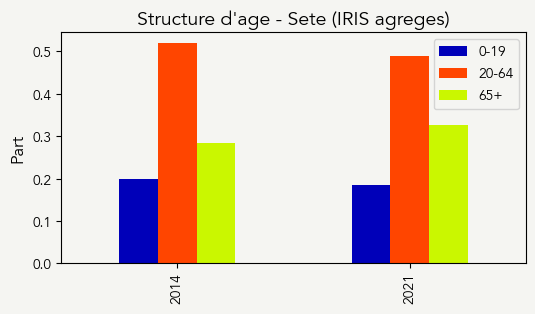

In [4]:
if "Population en 2014 (princ)" in socio14_sete.columns and "P21_POP" in socio21_sete.columns:
    pop14 = socio14_sete["Population en 2014 (princ)"].sum()
    pop21 = socio21_sete["P21_POP"].sum()
    age_compare = pd.DataFrame({
        "2014": {
            "0-19": socio14_sete["Pop 0-19 ans en 2014 (princ)"].sum() / pop14,
            "20-64": socio14_sete["Pop 20-64 ans en 2014 (princ)"].sum() / pop14,
            "65+": socio14_sete["Pop 65 ans ou plus en 2014 (princ)"].sum() / pop14,
        },
        "2021": {
            "0-19": socio21_sete["P21_POP0019"].sum() / pop21,
            "20-64": socio21_sete["P21_POP2064"].sum() / pop21,
            "65+": socio21_sete["P21_POP65P"].sum() / pop21,
        },
    }).T
    ax = age_compare.plot(kind="bar", figsize=(6, 3), color=COLOR_PALETTE)
    ax.set_title("Structure d'age - Sete (IRIS agreges)")
    ax.set_ylabel("Part")
    save_fig("Structure d'age - Sete (IRIS agreges)")
    plt.show()


In [5]:
# Note: pour relier socio-demo et bureaux, il faut une correspondance bureau <-> IRIS
# (non disponible dans les fichiers fournis). Ici, on reste sur des descriptifs IRIS.

if "IRIS" in socio21_sete.columns and "P21_POP" in socio21_sete.columns:
    iris_top = socio21_sete[["IRIS", "LAB_IRIS", "P21_POP"]].sort_values("P21_POP", ascending=False)
    iris_top.head(10)


In [6]:
# Deltas IRIS (2021 - 2014) sur quelques indicateurs simples
iris14_cols = [
    "IRIS",
    "Population en 2014 (princ)",
    "Pop 0-19 ans en 2014 (princ)",
    "Pop 20-64 ans en 2014 (princ)",
    "Pop 65 ans ou plus en 2014 (princ)",
]

iris21_cols = [
    "IRIS",
    "P21_POP",
    "P21_POP0019",
    "P21_POP2064",
    "P21_POP65P",
]

if set(iris14_cols).issubset(socio14_sete.columns) and set(iris21_cols).issubset(socio21_sete.columns):
    iris14 = socio14_sete[iris14_cols].copy()
    iris21 = socio21_sete[iris21_cols].copy()

    iris14["share_0_19_2014"] = iris14["Pop 0-19 ans en 2014 (princ)"] / iris14["Population en 2014 (princ)"].replace(0, np.nan)
    iris14["share_20_64_2014"] = iris14["Pop 20-64 ans en 2014 (princ)"] / iris14["Population en 2014 (princ)"].replace(0, np.nan)
    iris14["share_65p_2014"] = iris14["Pop 65 ans ou plus en 2014 (princ)"] / iris14["Population en 2014 (princ)"].replace(0, np.nan)

    iris21["share_0_19_2021"] = iris21["P21_POP0019"] / iris21["P21_POP"].replace(0, np.nan)
    iris21["share_20_64_2021"] = iris21["P21_POP2064"] / iris21["P21_POP"].replace(0, np.nan)
    iris21["share_65p_2021"] = iris21["P21_POP65P"] / iris21["P21_POP"].replace(0, np.nan)

    iris_delta = iris14.merge(iris21, on="IRIS", how="inner")
    iris_delta["delta_share_0_19"] = iris_delta["share_0_19_2021"] - iris_delta["share_0_19_2014"]
    iris_delta["delta_share_20_64"] = iris_delta["share_20_64_2021"] - iris_delta["share_20_64_2014"]
    iris_delta["delta_share_65p"] = iris_delta["share_65p_2021"] - iris_delta["share_65p_2014"]

    iris_delta[["IRIS", "delta_share_0_19", "delta_share_20_64", "delta_share_65p"]].sort_values(
        "delta_share_65p", ascending=False
    ).head(10)
else:
    print("Colonnes age IRIS manquantes pour le delta 2014-2021")


## 3) Rapport INSEE 2014 vs 2021 (RP) - tableaux & graphiques

Ce bloc reproduit la logique du rapport Insee avec les donnees disponibles dans le projet.
Les tables manquantes sont laissees vides (NaN) et notees explicitement.


In [7]:
# Parametres et sources (RP 2014 / RP 2021)

COMMUNE_LABEL = (
    socio14_sete["Libellé commune ou ARM"].iloc[0]
    if "Libellé commune ou ARM" in socio14_sete.columns and not socio14_sete.empty
    else "Sete"
)


YEAR_COLORS = {2014: COLOR_PRIMARY, 2021: COLOR_SECONDARY}

INSEE_SOURCES = {
    "RP2014": "data/sociodemo/pop-2014.csv (RP 2014, IRIS)",
    "RP2021": "data/sociodemo/pop-2021.csv (RP 2021, IRIS)",
}
INSEE_SOURCES


{'RP2014': 'data/sociodemo/pop-2014.csv (RP 2014, IRIS)',
 'RP2021': 'data/sociodemo/pop-2021.csv (RP 2021, IRIS)'}

In [8]:
# Table 1: population par grandes tranches d'age (2014 vs 2021)

def sum_if_exists(df: pd.DataFrame, col: str) -> float:
    if col not in df.columns:
        return float("nan")
    return float(pd.to_numeric(df[col], errors="coerce").sum())


age_groups = ["0-14", "15-29", "30-44", "45-59", "60-74", "75+"]

age_cols_2014 = {
    "0-14": "Pop 0-14 ans en 2014 (princ)",
    "15-29": "Pop 15-29 ans en 2014 (princ)",
    "30-44": "Pop 30-44 ans en 2014 (princ)",
    "45-59": "Pop 45-59 ans en 2014 (princ)",
    "60-74": "Pop 60-74 ans en 2014 (princ)",
    "75+": "Pop 75 ans ou plus en 2014 (princ)",
}

age_cols_2021 = {
    "0-14": "P21_POP0014",
    "15-29": "P21_POP1529",
    "30-44": "P21_POP3044",
    "45-59": "P21_POP4559",
    "60-74": "P21_POP6074",
    "75+": "P21_POP75P",
}

pop14_total = sum_if_exists(socio14_sete, "Population en 2014 (princ)")
pop21_total = sum_if_exists(socio21_sete, "P21_POP")

rows = []
for group in age_groups:
    v14 = sum_if_exists(socio14_sete, age_cols_2014[group])
    v21 = sum_if_exists(socio21_sete, age_cols_2021[group])
    rows.append({
        "annee": 2014,
        "tranche_age": group,
        "effectif": v14,
        "part": v14 / pop14_total if pop14_total else float("nan"),
    })
    rows.append({
        "annee": 2021,
        "tranche_age": group,
        "effectif": v21,
        "part": v21 / pop21_total if pop21_total else float("nan"),
    })

age_df = pd.DataFrame(rows)
age_df


annee tranche_age      effectif      part
0    2014        0-14   6262.000000  0.141873
1    2021        0-14   5928.463411  0.132592
2    2014       15-29   6830.000000  0.154742
3    2021       15-29   6137.098071  0.137258
4    2014       30-44   6685.000000  0.151457
5    2021       30-44   6260.690877  0.140023
6    2014       45-59   8446.000000  0.191354
7    2021       45-59   8432.670711  0.188600
8    2014       60-74   9710.000000  0.219992
9    2021       60-74  10908.569419  0.243974
10   2014         75+   6203.000000  0.140536
11   2021         75+   7044.507512  0.157553

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/population_par_age_effectifs_2014_2021.png


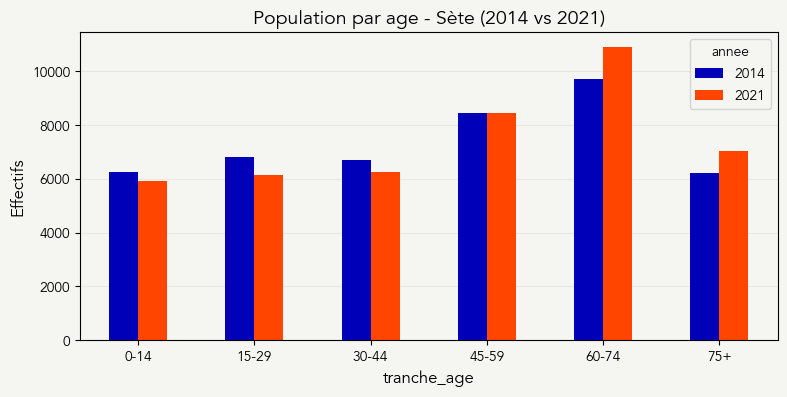

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/population_par_age_parts_2014_2021.png


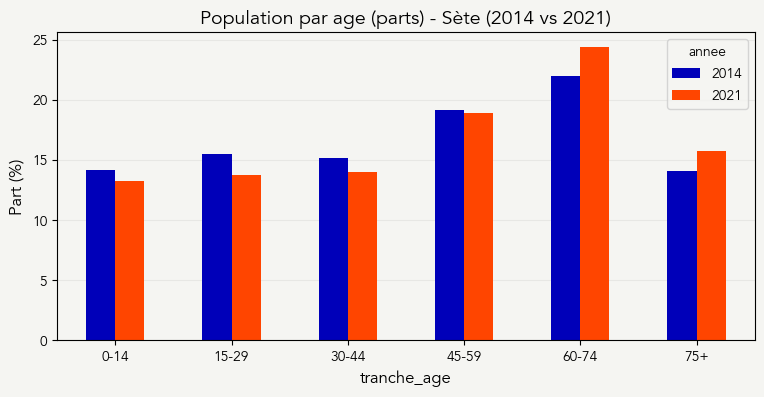

In [9]:
# Graphique: population par age (effectifs)

pivot_age = age_df.pivot(index="tranche_age", columns="annee", values="effectif").reindex(age_groups)
ax = pivot_age.plot(
    kind="bar",
    figsize=(9, 4),
    color=[YEAR_COLORS[2014], YEAR_COLORS[2021]],
)
ax.set_title(f"Population par age - {COMMUNE_LABEL} (2014 vs 2021)")
ax.set_ylabel("Effectifs")
ax.grid(True, axis="y", alpha=0.2)
ax.set_axisbelow(True)
plt.xticks(rotation=0)
save_fig("population_par_age_effectifs_2014_2021")
plt.show()

# Graphique: population par age (parts)
pivot_age_part = age_df.pivot(index="tranche_age", columns="annee", values="part").reindex(age_groups) * 100
ax = pivot_age_part.plot(
    kind="bar",
    figsize=(9, 4),
    color=[YEAR_COLORS[2014], YEAR_COLORS[2021]],
)
ax.set_title(f"Population par age (parts) - {COMMUNE_LABEL} (2014 vs 2021)")
ax.set_ylabel("Part (%)")
ax.grid(True, axis="y", alpha=0.2)
ax.set_axisbelow(True)
plt.xticks(rotation=0)
save_fig("population_par_age_parts_2014_2021")
plt.show()


In [10]:
# Table 2: population totale et densite

pop_table = pd.DataFrame([
    {"annee": 2014, "population": pop14_total, "densite_hab_km2": float("nan")},
    {"annee": 2021, "population": pop21_total, "densite_hab_km2": float("nan")},
])

pop_table


annee  population  densite_hab_km2
0   2014     44138.0              NaN
1   2021     44712.0              NaN

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/population_totale_2014_2021.png


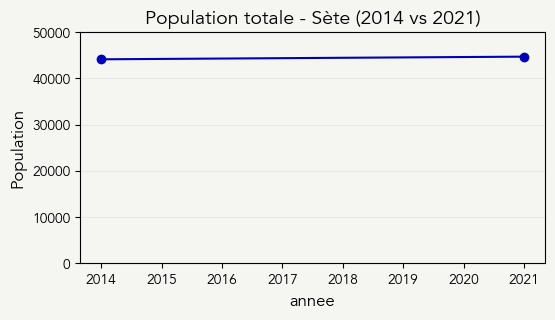

Densite: surface communale manquante (source Insee non fournie).


In [11]:
# Graphique: evolution de la population totale

ax = pop_table.plot(
    x="annee",
    y="population",
    marker="o",
    figsize=(6, 3),
    color=COLOR_PRIMARY,
    legend=False,
)
ax.set_title(f"Population totale - {COMMUNE_LABEL} (2014 vs 2021)")
ax.set_ylabel("Population")
ax.set_ylim(0, 50000)
ax.grid(True, axis="y", alpha=0.2)
ax.set_axisbelow(True)
save_fig("population_totale_2014_2021")
plt.show()

# Graphique: densite (si surface communale disponible)
if pop_table["densite_hab_km2"].notna().any():
    ax = pop_table.plot(
        x="annee",
        y="densite_hab_km2",
        marker="o",
        figsize=(6, 3),
        color=COLOR_PRIMARY,
        legend=False,
    )
    ax.set_title(f"Densite - {COMMUNE_LABEL} (2014 vs 2021)")
    ax.set_ylabel("Hab./km2")
    ax.grid(True, axis="y", alpha=0.2)
    ax.set_axisbelow(True)
    save_fig("densite_2014_2021")
    plt.show()
else:
    print("Densite: surface communale manquante (source Insee non fournie).")


In [12]:
# Table 3: categories socio-professionnelles (proxy emploi)

pcs_labels = [
    "agriculteurs",
    "artisans_commercants",
    "cadres",
    "prof_intermediaires",
    "employes",
    "ouvriers",
    "retraites",
    "autres",
]

pcs_cols_2014 = {
    "agriculteurs": "Pop 15 ans ou plus Agriculteurs exploitants en 2014 (compl)",
    "artisans_commercants": "Pop 15 ans ou plus Artisans, Comm., Chefs entr. en 2014 (compl)",
    "cadres": "Pop 15 ans ou plus Cadres, Prof. intel. sup. en 2014 (compl)",
    "prof_intermediaires": "Pop 15 ans ou plus Prof. intermédiaires en 2014 (compl)",
    "employes": "Pop 15 ans ou plus Employés en 2014 (compl)",
    "ouvriers": "Pop 15 ans ou plus Ouvriers en 2014 (compl)",
    "retraites": "Pop 15 ans ou plus Retraités en 2014 (compl)",
    "autres": "Pop 15 ans ou plus Autres en 2014 (compl)",
}

pcs_cols_2021 = {
    "agriculteurs": "C21_POP15P_CS1",
    "artisans_commercants": "C21_POP15P_CS2",
    "cadres": "C21_POP15P_CS3",
    "prof_intermediaires": "C21_POP15P_CS4",
    "employes": "C21_POP15P_CS5",
    "ouvriers": "C21_POP15P_CS6",
    "retraites": "C21_POP15P_CS7",
    "autres": "C21_POP15P_CS8",
}

pcs_den_2014 = sum_if_exists(socio14_sete, "Pop 15 ans ou plus en 2014 (compl)")
pcs_den_2021 = sum_if_exists(socio21_sete, "C21_POP15P")

pcs_rows = []
for label in pcs_labels:
    v14 = sum_if_exists(socio14_sete, pcs_cols_2014[label])
    v21 = sum_if_exists(socio21_sete, pcs_cols_2021[label])
    pcs_rows.append({
        "annee": 2014,
        "categorie": label,
        "effectif": v14,
        "part": v14 / pcs_den_2014 if pcs_den_2014 else float("nan"),
    })
    pcs_rows.append({
        "annee": 2021,
        "categorie": label,
        "effectif": v21,
        "part": v21 / pcs_den_2021 if pcs_den_2021 else float("nan"),
    })

pcs_df = pd.DataFrame(pcs_rows)
pcs_df


annee             categorie      effectif      part
0    2014          agriculteurs    137.000000  0.003618
1    2021          agriculteurs    134.713763  0.003477
2    2014  artisans_commercants   1349.000000  0.035622
3    2021  artisans_commercants   1433.324685  0.036994
4    2014                cadres   1768.000000  0.046686
5    2021                cadres   2323.681181  0.059975
6    2014   prof_intermediaires   3629.000000  0.095828
7    2021   prof_intermediaires   3908.246588  0.100872
8    2014              employes   5849.000000  0.154449
9    2021              employes   5282.513275  0.136342
10   2014              ouvriers   3621.000000  0.095617
11   2021              ouvriers   3208.650224  0.082816
12   2014             retraites  14009.000000  0.369923
13   2021             retraites  14882.034630  0.384108
14   2014                autres   7510.000000  0.198310
15   2021                autres   7571.280606  0.195416

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/pcs_effectifs_2014_2021.png


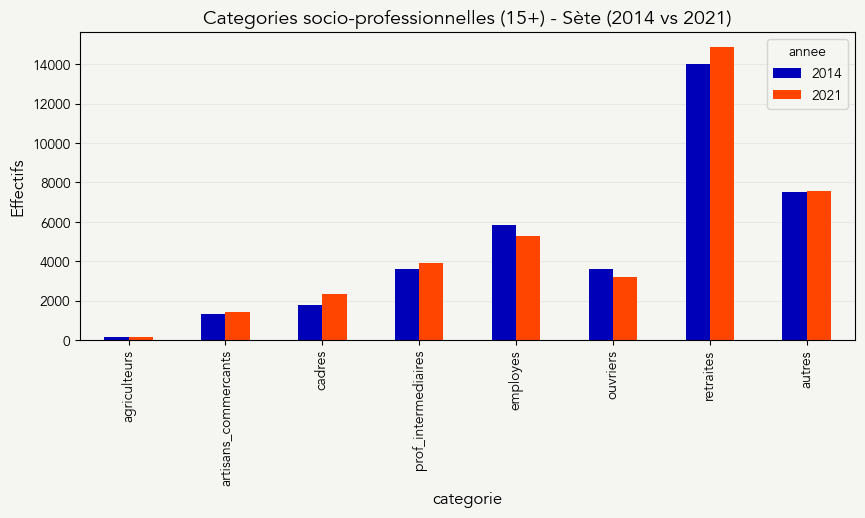

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/pcs_parts_2014_2021.png


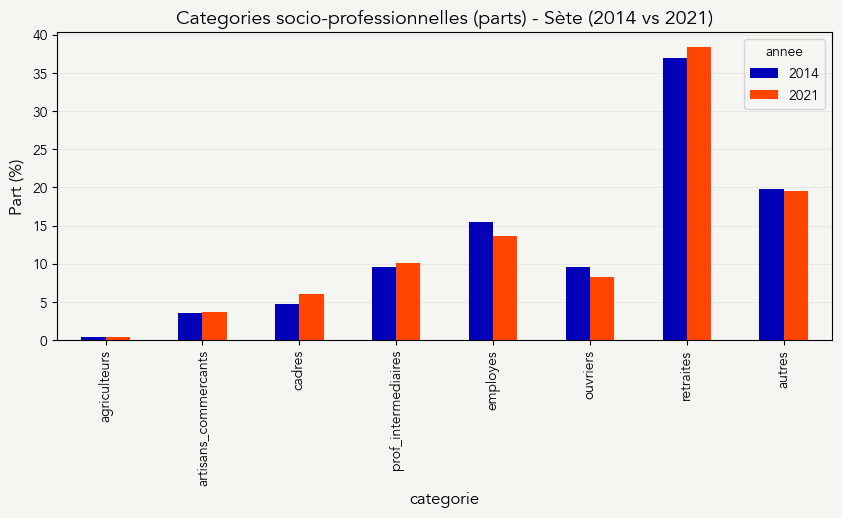

In [13]:
# Graphique: categories socio-professionnelles (effectifs)

pivot_pcs = pcs_df.pivot(index="categorie", columns="annee", values="effectif").reindex(pcs_labels)
ax = pivot_pcs.plot(
    kind="bar",
    figsize=(10, 4),
    color=[YEAR_COLORS[2014], YEAR_COLORS[2021]],
)
ax.set_title(f"Categories socio-professionnelles (15+) - {COMMUNE_LABEL} (2014 vs 2021)")
ax.set_ylabel("Effectifs")
ax.grid(True, axis="y", alpha=0.2)
ax.set_axisbelow(True)
plt.xticks(rotation=90)
save_fig("pcs_effectifs_2014_2021")
plt.show()

# Graphique: categories socio-professionnelles (parts)
pivot_pcs_part = pcs_df.pivot(index="categorie", columns="annee", values="part").reindex(pcs_labels) * 100
ax = pivot_pcs_part.plot(
    kind="bar",
    figsize=(10, 4),
    color=[YEAR_COLORS[2014], YEAR_COLORS[2021]],
)
ax.set_title(f"Categories socio-professionnelles (parts) - {COMMUNE_LABEL} (2014 vs 2021)")
ax.set_ylabel("Part (%)")
ax.grid(True, axis="y", alpha=0.2)
ax.set_axisbelow(True)
plt.xticks(rotation=90)
save_fig("pcs_parts_2014_2021")
plt.show()


**Limites et comparabilite**
- Densite: surface communale non fournie dans le projet.
- Indicateurs demographiques: donnees d'etat civil absentes.
- Menages, logements, statut d'occupation, diplomes, activite/emploi, revenus: fichiers Insee non fournis.
- Les valeurs sont calculees en agregant les IRIS de la commune (geographie constante).


## 4) Socio-demo : correlations et tendances d'evolution


In [14]:
# Correlations (pop-2014)

def corr_matrix(df: pd.DataFrame, min_non_null: float = 0.6) -> pd.DataFrame:
    num = df.select_dtypes(include=[np.number]).copy()
    num = num.loc[:, num.nunique(dropna=False) > 1]
    thresh = int(len(num) * min_non_null)
    num = num.dropna(axis=1, thresh=thresh)
    return num.corr()

corr14 = corr_matrix(socio14_sete)
corr21 = corr_matrix(socio21_sete)

print("corr14 shape:", corr14.shape)
print("corr21 shape:", corr21.shape)

corr14.round(2)


corr14 shape: (72, 72)
corr21 shape: (72, 72)


Population en 2014 (princ)  Pop 0-2 ans en 2014 (princ)  Pop 3-5 ans en 2014 (princ)  \
Population en 2014 (princ)                              1.00                         0.62                         0.61   
Pop 0-2 ans en 2014 (princ)                             0.62                         1.00                         0.92   
Pop 3-5 ans en 2014 (princ)                             0.61                         0.92                         1.00   
Pop 6-10 ans en 2014 (princ)                            0.71                         0.86                         0.93   
Pop 11-17 ans en 2014 (princ)                           0.79                         0.74                         0.79   
...                                                      ...                          ...                          ...   
Pop Français en 2014 (princ)                            0.99                         0.55                         0.55   
Pop Etrangers en 2014 (princ)                           0.37                         0.74                         0.68   
Pop Immigrés en 2014 (princ)                            0.45                         0.78                         0.74   
Pop ménages en 2014 (princ)                             1.00                         0.63                         0.63   
Pop hors ménages en 2014 (princ)                        0.18                        -0.08                        -0.13   

                                  Pop 6-10 ans en 2014 (princ)  Pop 11-17 ans en 2014 (princ)  Pop 18-24 ans en 2014 (princ)  \
Population en 2014 (princ)                                0.71                           0.79                           0.81   
Pop 0-2 ans en 2014 (princ)                               0.86                           0.74                           0.50   
Pop 3-5 ans en 2014 (princ)                               0.93                           0.79                           0.56   
Pop 6-10 ans en 2014 (princ)                              1.00                           0.88                           0.66   
Pop 11-17 ans en 2014 (princ)                             0.88                           1.00                           0.80   
...                                                        ...                            ...                            ...   
Pop Français en 2014 (princ)                              0.66                           0.73                           0.77   
Pop Etrangers en 2014 (princ)                             0.67                           0.67                           0.57   
Pop Immigrés en 2014 (princ)                              0.74                           0.74                           0.62   
Pop ménages en 2014 (princ)                               0.73                           0.78                           0.81   
Pop hors ménages en 2014 (princ)                         -0.12                           0.16                           0.16   

                                  Pop 25-39 ans en 2014 (princ)  Pop 40-54 ans en 2014 (princ)  Pop 55-64 ans en 2014 (princ)  \
Population en 2014 (princ)                                 0.89                           0.97                           0.91   
Pop 0-2 ans en 2014 (princ)                                0.73                           0.63                           0.31   
Pop 3-5 ans en 2014 (princ)                                0.80                           0.65                           0.29   
Pop 6-10 ans en 2014 (princ)                               0.78                           0.76                           0.47   
Pop 11-17 ans en 2014 (princ)                              0.72                           0.80                           0.60   
...                                                         ...                            ...                            ...   
Pop Français en 2014 (princ)                               0.87                           0.95                           0.93   


In [15]:
# Correlations (pop-2021)

corr21.round(2)


P21_POP  P21_POP0002  P21_POP0305  P21_POP0610  P21_POP1117  P21_POP1824  P21_POP2539  P21_POP4054  P21_POP5564  P21_POP6579  \
P21_POP         1.00         0.70         0.73         0.78         0.79         0.79         0.90         0.95         0.96         0.86   
P21_POP0002     0.70         1.00         0.92         0.81         0.84         0.70         0.81         0.74         0.53         0.31   
P21_POP0305     0.73         0.92         1.00         0.81         0.79         0.70         0.83         0.77         0.58         0.38   
P21_POP0610     0.78         0.81         0.81         1.00         0.90         0.77         0.81         0.85         0.66         0.41   
P21_POP1117     0.79         0.84         0.79         0.90         1.00         0.79         0.76         0.83         0.63         0.48   
...              ...          ...          ...          ...          ...          ...          ...          ...          ...          ...   
P21_POP_FR      1.00         0.66         0.69         0.74         0.75         0.76         0.88         0.93         0.97         0.88   
P21_POP_ETR     0.64         0.74         0.71         0.73         0.73         0.73         0.74         0.77         0.49         0.30   
P21_POP_IMM     0.72         0.83         0.78         0.84         0.84         0.78         0.78         0.83         0.57         0.37   
P21_PMEN        1.00         0.70         0.73         0.78         0.79         0.80         0.91         0.96         0.96         0.86   
P21_PHORMEN     0.16         0.18         0.01         0.08         0.10         0.01         0.07        -0.00         0.16         0.13   

             P21_POP80P  P21_POP0014  P21_POP1529  P21_POP3044  P21_POP4559  P21_POP6074  P21_POP75P  P21_POP0019  P21_POP2064  \
P21_POP            0.88         0.80         0.90         0.90         0.98         0.88        0.89         0.83         0.98   
P21_POP0002        0.52         0.93         0.82         0.80         0.68         0.36        0.45         0.91         0.74   
P21_POP0305        0.50         0.92         0.80         0.83         0.70         0.45        0.44         0.89         0.77   
P21_POP0610        0.52         0.95         0.85         0.86         0.77         0.49        0.49         0.95         0.82   
P21_POP1117        0.55         0.95         0.88         0.79         0.77         0.52        0.54         0.96         0.79   
...                 ...          ...          ...          ...          ...          ...         ...          ...          ...   
P21_POP_FR         0.90         0.76         0.86         0.88         0.97         0.91        0.92         0.79         0.96   
P21_POP_ETR        0.37         0.77         0.80         0.72         0.71         0.35        0.34         0.79         0.72   
P21_POP_IMM        0.47         0.88         0.85         0.77         0.76         0.43        0.42         0.89         0.78   
P21_PMEN           0.86         0.80         0.90         0.90         0.98         0.88        0.87         0.83         0.98   
P21_PHORMEN        0.48         0.08        -0.00         0.09         0.09         0.13        0.37         0.10         0.07   

             P21_POP65P  P21_POPH  P21_H0014  P21_H1529  P21_H3044  P21_H4559  P21_H6074  P21_H75P  P21_H0019  P21_H2064  P21_H65P  ...  \
P21_POP            0.90      0.99       0.78       0.92       0.88       0.98       0.84      0.83       0.81       0.98      0.84  ...   
P21_POP0002        0.40      0.67       0.89       0.76       0.75       0.69       0.33      0.34       0.86       0.71      0.32  ...   
P21_POP0305        0.44      0.72       0.90       0.77       0.76       0.71       0.42      0.37       0.86       0.75      0.38  ...   
P21_POP0610        0.47      0.77       0.92       0.82       0.82       0.80       0.46      0.40       0.91       0.82      0.40  ...   
P21_POP1117        0.52      0.78       0.96       0.86       0.

In [16]:
# Variables tres correlees (suggestions de fusion)

def high_corr_pairs(corr: pd.DataFrame, threshold: float = 0.9) -> pd.DataFrame:
    pairs = []
    cols = list(corr.columns)
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            val = corr.iloc[i, j]
            if pd.notna(val) and abs(val) >= threshold:
                pairs.append((cols[i], cols[j], val))
    pairs = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
    return pd.DataFrame(pairs, columns=["var_1", "var_2", "corr"])

pairs14 = high_corr_pairs(corr14)
pairs21 = high_corr_pairs(corr21)

print("Top correlations pop-2014:")
print(pairs14.head(20))

print("Top correlations pop-2021:")
print(pairs21.head(20))


def corr_clusters(pairs: pd.DataFrame) -> list[list[str]]:
    parent: dict[str, str] = {}

    def find(x: str) -> str:
        parent.setdefault(x, x)
        if parent[x] != x:
            parent[x] = find(parent[x])
        return parent[x]

    def union(a: str, b: str) -> None:
        ra, rb = find(a), find(b)
        if ra != rb:
            parent[rb] = ra

    for _, row in pairs.iterrows():
        union(row["var_1"], row["var_2"])

    groups: dict[str, list[str]] = {} 
    for x in parent:
        root = find(x)
        groups.setdefault(root, []).append(x)

    clusters = [sorted(g) for g in groups.values() if len(g) > 1]
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

print("Clusters pop-2014 (corr >= 0.9):", corr_clusters(pairs14)[:10])
print("Clusters pop-2021 (corr >= 0.9):", corr_clusters(pairs21)[:10])


Top correlations pop-2014:
                                           var_1                                              var_2      corr
0                     Population en 2014 (princ)                        Pop ménages en 2014 (princ)  0.998163
1                     Population en 2014 (princ)                         Pop Femmes en 2014 (princ)  0.998131
2                     Population en 2014 (princ)                         Pop Hommes en 2014 (princ)  0.997368
3             Pop 15 ans ou plus en 2014 (compl)          Pop 15 ans ou plus Femmes en 2014 (compl)  0.997249
4             Pop 15 ans ou plus en 2014 (compl)          Pop 15 ans ou plus Hommes en 2014 (compl)  0.996152
5                     Pop Femmes en 2014 (princ)                        Pop ménages en 2014 (princ)  0.995987
6                     Pop Hommes en 2014 (princ)                        Pop ménages en 2014 (princ)  0.995875
7      Pop Hommes 65 ans ou plus en 2014 (princ)  Pop 15 ans ou plus Hommes Retraités en 2014

In [17]:
# Comparaison 2014 vs 2021 : tendances d'evolution (Sete, agregat IRIS)

def sum_if_exists(df: pd.DataFrame, col: str) -> float:
    return float(df[col].sum()) if col in df.columns else float("nan")

pop14 = sum_if_exists(socio14_sete, "Population en 2014 (princ)")
pop21 = sum_if_exists(socio21_sete, "P21_POP")

metrics = [
    ("pop_total", "Population en 2014 (princ)", "P21_POP", "level"),
    ("part_0_19", "Pop 0-19 ans en 2014 (princ)", "P21_POP0019", "share"),
    ("part_20_64", "Pop 20-64 ans en 2014 (princ)", "P21_POP2064", "share"),
    ("part_65_plus", "Pop 65 ans ou plus en 2014 (princ)", "P21_POP65P", "share"),
    ("part_hommes", "Pop Hommes en 2014 (princ)", "P21_POPH", "share"),
    ("part_femmes", "Pop Femmes en 2014 (princ)", "P21_POPF", "share"),
    ("part_francais", "Pop Francais en 2014 (princ)", "P21_POP_FR", "share"),
    ("part_etrangers", "Pop Etrangers en 2014 (princ)", "P21_POP_ETR", "share"),
    ("part_immigres", "Pop Immigres en 2014 (princ)", "P21_POP_IMM", "share"),
    ("part_menages", "Pop menages en 2014 (princ)", "P21_PMEN", "share"),
    ("part_hors_menages", "Pop hors menages en 2014 (princ)", "P21_PHORMEN", "share"),
    ("pop_15p", "Pop 15 ans ou plus en 2014 (compl)", "C21_POP15P", "level"),
]

rows = []
for label, col14, col21, kind in metrics:
    if col14 not in socio14_sete.columns or col21 not in socio21_sete.columns:
        continue
    v14 = sum_if_exists(socio14_sete, col14)
    v21 = sum_if_exists(socio21_sete, col21)
    if kind == "share" and pop14 and pop21:
        v14 = v14 / pop14
        v21 = v21 / pop21
    rows.append({
        "indicator": label,
        "type": kind,
        "value_2014": v14,
        "value_2021": v21,
        "delta": v21 - v14,
    })

trend_df = pd.DataFrame(rows).sort_values("delta", ascending=False)
trend_df


indicator   type    value_2014    value_2021       delta
7         pop_15p  level  37870.000000  38744.444953  874.444953
0       pop_total  level  44138.000000  44712.000000  574.000000
3    part_65_plus  share      0.282953      0.326727    0.043773
5     part_femmes  share      0.533033      0.539907    0.006874
6  part_etrangers  share      0.061013      0.067694    0.006680
4     part_hommes  share      0.466967      0.460093   -0.006874
1       part_0_19  share      0.198287      0.184864   -0.013424
2      part_20_64  share      0.518782      0.488410   -0.030372

Couleurs complementaires utilisees : #FF4500 et #CAF700.


Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des parts (2014 -> 2021).png


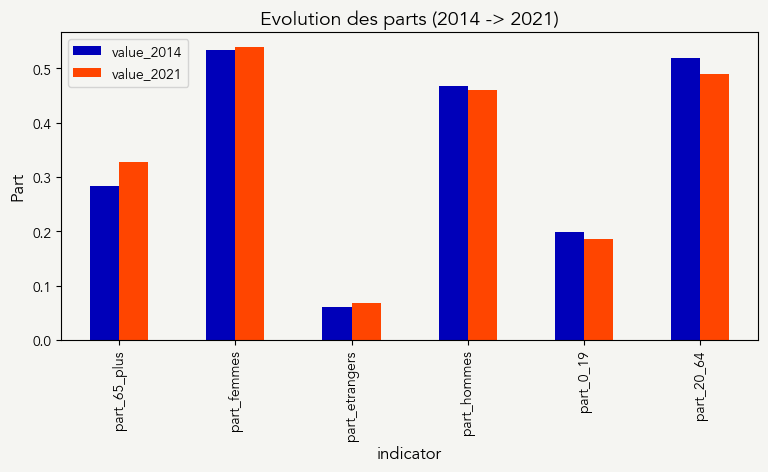

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Delta des parts (2021 - 2014).png


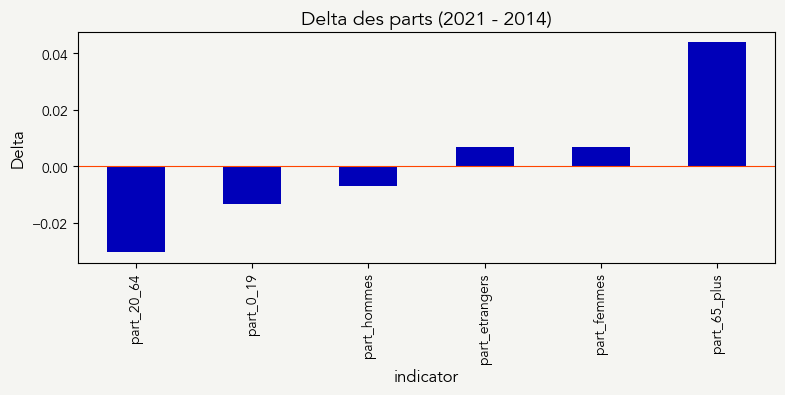

In [18]:
# Visualisation des tendances (parts)
share_trend = trend_df[trend_df["type"] == "share"].set_index("indicator")
if not share_trend.empty:
    ax = share_trend[["value_2014", "value_2021"]].plot(kind="bar", figsize=(9, 4), color=[COLOR_PRIMARY, COLOR_SECONDARY])
    ax.set_title("Evolution des parts (2014 -> 2021)")
    ax.set_ylabel("Part")
    save_fig("Evolution des parts (2014 -> 2021)")
    plt.show()

    ax = share_trend["delta"].sort_values().plot(kind="bar", figsize=(9, 3), color=COLOR_PRIMARY)
    ax.set_title("Delta des parts (2021 - 2014)")
    ax.set_ylabel("Delta")
    plt.axhline(0, color=COLOR_SECONDARY, linewidth=0.8)
    save_fig("Delta des parts (2021 - 2014)")
    plt.show()


## Partie 2 : les élections


Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/carte_participation_legislatives_tour1_2022-06-12.png


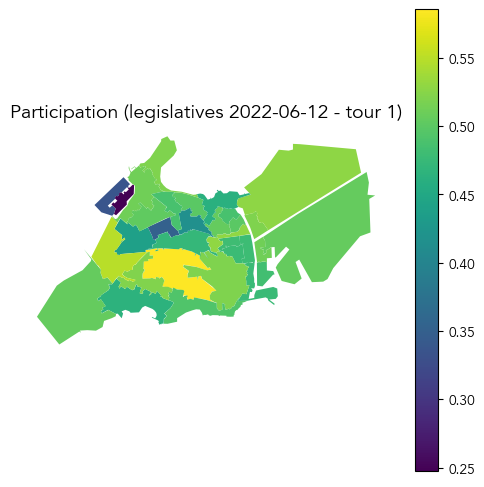

In [19]:
# Cartographie geopandas
GEO_PATH = DATA_DIR / "geo" / "bdv_s_te.geojson"


import geopandas as gpd

gdf = gpd.read_file(GEO_PATH)
gdf["bureau"] = gdf["name"].astype(str).str.extract(r"(\d+)").fillna("0")[0].str.zfill(4)

if "base_bv" in globals():
    map_base = base_bv.copy()
else:
    map_base = (
        elections_sete
        .groupby(["code_bv", "bureau", "date_scrutin", "type_scrutin", "tour", "annee"], as_index=False)
        [["inscrits", "votants"]]
        .agg("first")
    )

if "taux_participation" not in map_base.columns:
    map_base["taux_participation"] = (
        map_base["votants"] / map_base["inscrits"].replace(0, np.nan)
    )

map_base["date_scrutin"] = pd.to_datetime(map_base["date_scrutin"], errors="coerce")

FOCUS_TYPE = CONFIG["focus_type"]
FOCUS_TOUR = CONFIG["focus_tour"]
focus_year = CONFIG.get("focus_year")

map_focus = map_base[
    (map_base["type_scrutin"] == FOCUS_TYPE)
    & (map_base["tour"] == FOCUS_TOUR)
].copy()

if focus_year is not None and "annee" in map_focus.columns:
    map_focus = map_focus[map_focus["annee"] == focus_year]

if map_focus.empty:
    raise ValueError(f"Aucun scrutin {FOCUS_TYPE} tour {FOCUS_TOUR} pour la carte")

focus_date = map_focus["date_scrutin"].max()
map_focus = map_focus[map_focus["date_scrutin"] == focus_date].copy()

map_df = gdf.merge(
    map_focus[["bureau", "taux_participation"]],
    on="bureau",
    how="left",
)

ax = map_df.plot(column="taux_participation", legend=True, figsize=(6, 6))
ax.set_facecolor("white")
ax.figure.set_facecolor("white")
ax.set_title(f"Participation ({FOCUS_TYPE} {focus_date.date()} - tour {FOCUS_TOUR})")
ax.set_axis_off()
save_fig(f"carte_participation_{FOCUS_TYPE}_tour{FOCUS_TOUR}_{focus_date.date()}")
plt.show()


In [20]:
EVENT_COLS = ["date_scrutin", "type_scrutin", "tour", "annee"]
BV_COLS = ["code_bv", "bureau"] + EVENT_COLS

base_bv = (
    elections_sete
    .groupby(BV_COLS, as_index=False)[
        ["inscrits", "votants", "exprimes", "abstentions", "blancs", "nuls"]
    ]
    .agg("first")
)


def constant_perimeter_codes(
    df: pd.DataFrame, type_scrutin: str, tour: int | None = None
) -> set[str]:
    sub = df[df["type_scrutin"] == type_scrutin]
    if tour is not None:
        sub = sub[sub["tour"] == tour]
    if sub.empty:
        return set()
    by_date = (
        sub.groupby("date_scrutin")["code_bv"]
        .apply(lambda s: set(s))
        .tolist()
    )
    return set.intersection(*by_date)


CONSTANT_BV_CODES = constant_perimeter_codes(
    base_bv,
    CONFIG["constant_perimeter_type"],
    CONFIG["constant_perimeter_tour"],
)

if CONFIG["constant_perimeter"]:
    if not CONSTANT_BV_CODES:
        raise ValueError("Perimetre constant vide: verifier type/tour")
    base_bv = base_bv[base_bv["code_bv"].isin(CONSTANT_BV_CODES)].copy()

base_bv["taux_participation"] = base_bv["votants"] / base_bv["inscrits"].replace(0, np.nan)
base_bv["taux_exprimes"] = base_bv["exprimes"] / base_bv["inscrits"].replace(0, np.nan)
base_bv["taux_blancs_nuls_inscrits"] = (
    (base_bv["blancs"] + base_bv["nuls"]) / base_bv["inscrits"].replace(0, np.nan)
)


In [21]:
MAPPING_PATH = CONFIG["mapping_path"]
mapping = pd.read_csv(MAPPING_PATH, sep=";")
mapping["code_candidature"] = mapping["code_candidature"].astype(str).str.strip().str.upper()

ALLOWED_NUANCES = [
    "extreme_gauche",
    "gauche_dure",
    "gauche_moderee",
    "centre",
    "droite_moderee",
    "droite_dure",
    "extreme_droite",
]

NUANCE_MAP = {
    "gauche_modere": "gauche_moderee",
    "gauche": "gauche_moderee",
    "droite_modere": "droite_moderee",
    "droite": "droite_moderee",
}

NUANCE_COLORS = {
    "extreme_gauche": "#7f1d1d",
    "gauche_dure": "#ff0000",
    "gauche_moderee": "#f472b6",
    "centre": "#facc15",
    "droite_moderee": "#60a5fa",
    "droite_dure": "#1e3a8a",
    "extreme_droite": "#8b4513",
}

def nuance_colors_for(cols: list[str]) -> list[str]:
    return [NUANCE_COLORS.get(c, COLOR_PRIMARY) for c in cols]


def build_candidates_long(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    required_cols = [
        "code_bv",
        "annee",
        "date_scrutin",
        "type_scrutin",
        "tour",
        "inscrits",
        "votants",
        "exprimes",
        "abstentions",
        "blancs",
        "nuls",
    ]
    for col in required_cols:
        if col not in df.columns:
            df[col] = np.nan

    voix_cols = [c for c in df.columns if re.match(r"^Voix \d+$", c)]
    has_numbered_voix = bool(voix_cols) and df[voix_cols].notna().any().any()

    base_cols = required_cols + [c for c in ["nom_bv", "nom_candidature"] if c in df.columns]

    def _compose_nom(idx: int) -> pd.Series | None:
        series = pd.Series(pd.NA, index=df.index, dtype="string")
        etendu_col = f"Libellé Etendu Liste {idx}"
        abrege_col = f"Libellé Abrégé Liste {idx}"
        nom_col = f"Nom {idx}"
        prenom_col = f"Prénom {idx}"

        if etendu_col in df.columns:
            series = series.fillna(df[etendu_col].astype("string"))
        if abrege_col in df.columns:
            series = series.fillna(df[abrege_col].astype("string"))
        if nom_col in df.columns and prenom_col in df.columns:
            prenom = df[prenom_col].fillna("").astype(str).str.strip()
            nom = df[nom_col].fillna("").astype(str).str.strip()
            combined = (prenom + " " + nom).str.strip().replace("", pd.NA)
            series = series.fillna(combined)
        elif nom_col in df.columns:
            series = series.fillna(df[nom_col].astype("string"))
        elif prenom_col in df.columns:
            series = series.fillna(df[prenom_col].astype("string"))

        if series.isna().all():
            return None
        return series

    if has_numbered_voix:
        indices = sorted({int(c.split()[-1]) for c in voix_cols})
        frames = []
        for idx in indices:
            voix_col = f"Voix {idx}"
            if voix_col not in df.columns:
                continue
            temp = df[base_cols].copy()
            temp["voix"] = df[voix_col]
            if f"Code Nuance {idx}" in df.columns:
                temp["code_candidature_raw"] = df[f"Code Nuance {idx}"]
                if f"Nuance {idx}" in df.columns:
                    temp["code_candidature_raw"] = temp["code_candidature_raw"].fillna(
                        df[f"Nuance {idx}"]
                    )
            elif f"Nuance {idx}" in df.columns:
                temp["code_candidature_raw"] = df[f"Nuance {idx}"]
            else:
                temp["code_candidature_raw"] = np.nan

            nom_series = _compose_nom(idx)
            if nom_series is not None:
                temp["nom_candidature"] = nom_series

            temp["idx"] = idx
            frames.append(temp)
        long_df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(
            columns=base_cols + ["idx", "voix", "code_candidature_raw"]
        )
    elif "voix" in df.columns:
        long_df = df[base_cols + ["voix"]].copy()
        if "code_candidature" in df.columns:
            long_df["code_candidature_raw"] = df["code_candidature"]
        elif "code_candidature_raw" in df.columns:
            long_df["code_candidature_raw"] = df["code_candidature_raw"]
        elif "Code Nuance" in df.columns:
            long_df["code_candidature_raw"] = df["Code Nuance"]
        elif "Nuance" in df.columns:
            long_df["code_candidature_raw"] = df["Nuance"]
        else:
            long_df["code_candidature_raw"] = np.nan
        long_df["idx"] = 1
        long_df = long_df[base_cols + ["idx", "voix", "code_candidature_raw"]]
    else:
        long_df = pd.DataFrame(columns=base_cols + ["idx", "voix", "code_candidature_raw"])

    long_df["code_candidature_raw"] = (
        long_df["code_candidature_raw"].astype(str).str.strip().str.upper()
    )
    long_df.loc[
        long_df["code_candidature_raw"].isin(["", "NAN", "NONE", "<NA>", "NA", "N/A", "NULL"]),
        "code_candidature_raw",
    ] = np.nan

    if "nom_candidature" in long_df.columns:
        long_df["nom_candidature"] = long_df["nom_candidature"].astype("string").str.strip()
        long_df["nom_candidature"] = long_df["nom_candidature"].replace("", pd.NA)

    long_df["voix"] = pd.to_numeric(long_df["voix"], errors="coerce")
    long_df = long_df[long_df["voix"].notna() & (long_df["voix"] > 0)]

    return long_df


voix_num_cols = [col for col in elections_sete.columns if re.match(r"^Voix \d+$", col)]
if voix_num_cols:
    wide_mask = elections_sete[voix_num_cols].notna().any(axis=1)
    df_long = elections_sete[~wide_mask].copy()
    df_wide = elections_sete[wide_mask].copy()
    candidates_long = pd.concat(
        [build_candidates_long(df_long), build_candidates_long(df_wide)],
        ignore_index=True,
    )
else:
    candidates_long = build_candidates_long(elections_sete)

candidates_long["date_scrutin"] = pd.to_datetime(candidates_long["date_scrutin"], errors="coerce")

candidates_long = candidates_long.merge(
    mapping,
    how="left",
    left_on="code_candidature_raw",
    right_on="code_candidature",
)

mapping_codes = set(mapping["code_candidature"].dropna())

from IPython.display import display

missing_code_rows = candidates_long[
    candidates_long["code_candidature_raw"].notna()
    & ~candidates_long["code_candidature_raw"].isin(mapping_codes)
].copy()

missing_code_summary = (
    missing_code_rows
    .groupby("code_candidature_raw", as_index=False)
    .agg({"voix": "sum"})
    .sort_values("voix", ascending=False)
)

display(missing_code_summary.head(30))

missing_null_rows = candidates_long[candidates_long["code_candidature_raw"].isna()].copy()
missing_null_summary = (
    missing_null_rows
    .groupby("type_scrutin", as_index=False)
    .agg({"voix": "sum"})
    .sort_values("voix", ascending=False)
)

display(missing_null_summary.head(20))

missing_null_examples = (
    missing_null_rows
    .sort_values("voix", ascending=False)
    .head(30)
)

display(missing_null_examples[[
    "date_scrutin", "type_scrutin", "tour", "code_bv", "nom_candidature", "voix"
] ] if set(["date_scrutin", "type_scrutin", "tour", "code_bv", "nom_candidature", "voix"]).issubset(missing_null_examples.columns) else missing_null_examples.head(30))

mapped_mask = (
    candidates_long["bloc_1"].notna()
    | candidates_long["bloc_2"].notna()
    | candidates_long["bloc_3"].notna()
)

missing_bloc_rows = candidates_long[~mapped_mask].copy()
missing_bloc_summary = (
    missing_bloc_rows
    .groupby("code_candidature_raw", as_index=False)
    .agg({"voix": "sum"})
    .sort_values("voix", ascending=False)
)

display(missing_bloc_summary.head(30))

candidates_long["mapped_voix"] = candidates_long["voix"].where(
    mapped_mask, 0
)

mapping_coverage = (
    candidates_long
    .groupby(["date_scrutin", "type_scrutin", "tour"], as_index=False)
    .agg(total_voix=("voix", "sum"), mapped_voix=("mapped_voix", "sum"))
)
mapping_coverage["coverage"] = (
    mapping_coverage["mapped_voix"] / mapping_coverage["total_voix"].replace(0, np.nan)
)

mapping_coverage.sort_values("coverage").head(10)

min_coverage = mapping_coverage["coverage"].min()
mapping_incomplete = bool(pd.notna(min_coverage) and min_coverage < 0.98)
if mapping_incomplete:
    nullish_codes = {"<NA>", "NA", "NAN", "NONE", "NULL", "N/A", ""}
    def _clean_codes(series):
        codes = series.dropna().astype(str).str.strip().str.upper().tolist()
        return [c for c in codes if c not in nullish_codes]

    missing_codes = _clean_codes(missing_code_summary["code_candidature_raw"])[:50]
    missing_bloc_codes = _clean_codes(missing_bloc_summary["code_candidature_raw"])[:50]
    missing_codes_msg = missing_codes if missing_codes else "aucun (codes manquants = NaN dans les donnees)"
    missing_bloc_msg = missing_bloc_codes if missing_bloc_codes else "aucun (codes sans bloc = NaN dans les donnees)"
    print(
        "Mapping incomplet: completer data/mapping_candidats_blocs.csv. "
        f"Codes manquants (top 50): {missing_codes_msg}. "
        f"Codes sans bloc (top 50): {missing_bloc_msg}. "
        "Voir missing_null_summary / missing_null_examples pour les lignes sans code."
    )

candidates_long["bloc_1_final"] = (
    candidates_long["bloc_1"]
    .fillna(candidates_long["bloc_2"])
    .fillna(candidates_long["bloc_3"])
    .fillna("autre")
)

if "nom_candidature_x" in candidates_long.columns:
    candidates_long["nom_candidature"] = candidates_long["nom_candidature_x"]
    if "nom_candidature_y" in candidates_long.columns:
        candidates_long["nom_candidature"] = candidates_long["nom_candidature"].fillna(
            candidates_long["nom_candidature_y"]
        )
elif "nom_candidature" not in candidates_long.columns:
    candidates_long["nom_candidature"] = candidates_long["code_candidature_raw"]

candidates_long["nom_candidature"] = (
    candidates_long["nom_candidature"]
    .replace("", pd.NA)
    .fillna(candidates_long["code_candidature_raw"])
)

candidates_long = (
    candidates_long
    .groupby(
        [
            "code_bv",
            "date_scrutin",
            "type_scrutin",
            "tour",
            "nom_candidature",
            "bloc_1_final",
        ],
        as_index=False,
        dropna=False,
    )
    .agg(
        {
            "voix": "max",
            "exprimes": "first",
            "inscrits": "first",
            "votants": "first",
            "abstentions": "first",
            "blancs": "first",
            "nuls": "first",
            "annee": "first",
            "code_candidature_raw": "first",
        }
    )
)

candidates_long["code_bv"] = candidates_long["code_bv"].astype(str).str.zfill(9)
candidates_long["code_commune"] = candidates_long["code_bv"].str[:5]
candidates_long["bureau"] = candidates_long["code_bv"].str[-4:]

print("candidates_long.shape", candidates_long.shape)


code_candidature_raw    voix
0                   UG  7534.0

type_scrutin     voix
1  presidentielles  90253.0
0      europeennes  15735.0

code_bv  annee date_scrutin     type_scrutin  tour  inscrits  votants  exprimes  abstentions  blancs  nuls  nom_bv  \
582   343010011   2017   2017-05-07  presidentielles     2      1033      801       700        232.0    78.0  23.0     NaN   
579   343010008   2017   2017-05-07  presidentielles     2      1007      801       691        206.0    73.0  37.0     NaN   
914   343010008   2022   2022-04-24  presidentielles     2       966      789       722        177.0    46.0  21.0     NaN   
922   343010016   2022   2022-04-24  presidentielles     2      1213      844       754        369.0    58.0  32.0     NaN   
917   343010011   2022   2022-04-24  presidentielles     2      1038      763       695        275.0    48.0  20.0     NaN   
1403  343010027   2022   2022-04-24  presidentielles     2      1154      856       763        298.0    52.0  41.0     NaN   
918   343010012   2022   2022-04-24  presidentielles     2      1208      904       824        304.0    57.0  23.0     NaN   
921   343010015   2022   2022-04-24  presidentielles     2      1115      837       768        278.0    52.0  17.0     NaN   
916   343010010   2022   2022-04-24  presidentielles     2      1265      861       766        404.0    63.0  32.0     NaN   
581   343010010   2017   2017-05-07  presidentielles     2      1175      843       746        332.0    58.0  39.0     NaN   
1079  343010019   2017   2017-05-07  presidentielles     2      1238      872       785        366.0    59.0  28.0     NaN   
578   343010007   2017   2017-05-07  presidentielles     2      1134      851       741        283.0    76.0  34.0     NaN   
911   343010005   2022   2022-04-24  presidentielles     2      1090      729       660        361.0    54.0  15.0     NaN   
587   343010016   2017   2017-05-07  presidentielles     2      1067      794       660        273.0    94.0  40.0     NaN   
595   343010024   2017   2017-05-07  presidentielles     2      1182      809       717        373.0    62.0  30.0     NaN   
1405  343010029   2022   2022-04-24  presidentielles     2      1100      858       788        242.0    43.0  27.0     NaN   
576   343010005   2017   2017-05-07  presidentielles     2      1059      767       663        292.0    72.0  32.0     NaN   
586   343010015   2017   2017-05-07  presidentielles     2      1098      832       716        266.0    80.0  36.0     NaN   
913   343010007   2022   2022-04-24  presidentielles     2      1191      846       782        345.0    45.0  19.0     NaN   
597   343010026   2017   2017-05-07  presidentielles     2      1098      687       662        411.0    20.0   5.0     NaN   
577   343010006   2017   2017-05-07  presidentielles     2      1122      797       683        325.0    78.0  36.0     NaN   
592   343010021   2017   2017-05-07  presidentielles     2      1160      878       766        282.0    88.0  24.0     NaN   
1087  343010027   2017   2017-05-07  presidentielles     2      1141      904       770        237.0    76.0  58.0     NaN   
589   343010018   2017   2017-05-07  presidentielles     2      1153      874       762        279.0    70.0  42.0     NaN   
583   343010012   2017   2017-05-07  presidentielles     2      1121      843       744        278.0    71.0  28.0     NaN   
584   343010013   2017   2017-05-07  presidentielles     2       968      707       633        261.0    37.0  37.0     NaN   
930   343010024   2022   2022-04-24  presidentielles     2      1177      744       695        433.0    24.0  25.0     NaN   
1388  343010012   2022   2022-04-24  presidentielles     2      1208      904       824        304.0    57.0  23.0     NaN   
598   343010027   2017   2017-05-07  presidentielles     2      1141      904       770        237.0    76.0  58.0     NaN   
3258  343010008   2017   2017-04-23  presidentielles     1      1007      869       849        138.0    15.0   5.0     NaN   

      nom_candidature_x  idx   voix code_candidature_raw code_candidature nom_candidature_y bloc_1 bl

code_candidature_raw    voix
0                   UG  7534.0

Mapping incomplet: completer data/mapping_candidats_blocs.csv. Codes manquants (top 50): ['UG']. Codes sans bloc (top 50): ['UG']. Voir missing_null_summary / missing_null_examples pour les lignes sans code.
candidates_long.shape (4305, 17)


In [22]:
BLOC_COLS = ["code_bv", "bureau", "date_scrutin", "type_scrutin", "tour", "annee", "bloc_1_final"]
# code_bv est la cle principale; bureau sert de label.

bloc_bv = (
    candidates_long
    .groupby(BLOC_COLS, as_index=False)
    .agg(
        {
            "voix": "sum",
            "exprimes": "first",
            "inscrits": "first",
            "votants": "first",
            "blancs": "first",
            "nuls": "first",
            "abstentions": "first",
        }
    )
)

bloc_bv["part_bloc_exprimes"] = bloc_bv["voix"] / bloc_bv["exprimes"].replace(0, np.nan)
bloc_bv["part_bloc_inscrits"] = bloc_bv["voix"] / bloc_bv["inscrits"].replace(0, np.nan)
bloc_bv["score_inscrits"] = bloc_bv["voix"] / bloc_bv["inscrits"].replace(0, np.nan)

if CONFIG["constant_perimeter"]:
    bloc_bv = bloc_bv[bloc_bv["code_bv"].isin(CONSTANT_BV_CODES)].copy()

bloc_bv.head()


code_bv bureau date_scrutin type_scrutin  tour  annee    bloc_1_final   voix  exprimes  inscrits  votants  blancs  nuls  abstentions  \
0  343010001   0001   2014-05-25  europeennes     1   2014          centre   35.0       399       906      410     NaN   NaN        496.0   
1  343010001   0001   2014-05-25  europeennes     1   2014   droite_modere  113.0       399       906      410     NaN   NaN        496.0   
2  343010001   0001   2014-05-25  europeennes     1   2014  extreme_droite  142.0       399       906      410     NaN   NaN        496.0   
3  343010001   0001   2014-05-25  europeennes     1   2014     gauche_dure   29.0       399       906      410     NaN   NaN        496.0   
4  343010001   0001   2014-05-25  europeennes     1   2014   gauche_modere   80.0       399       906      410     NaN   NaN        496.0   

   part_bloc_exprimes  part_bloc_inscrits  score_inscrits  
0            0.087719            0.038631        0.038631  
1            0.283208            0.124724        0.124724  
2            0.355890            0.156733        0.156733  
3            0.072682            0.032009        0.032009  
4            0.200501            0.088300        0.088300

## 6) Participation


In [23]:
# A garder
city_event = (
    base_bv
    .groupby(EVENT_COLS, as_index=False)
    .agg(
        {
            "inscrits": "sum",
            "votants": "sum",
            "exprimes": "sum",
            "blancs": "sum",
            "nuls": "sum",
            "abstentions": "sum",
        }
    )
    .sort_values("date_scrutin")
)

den_i = city_event["inscrits"].replace(0, np.nan)
den_v = city_event["votants"].replace(0, np.nan)

city_event = city_event.assign(
    taux_participation=city_event["votants"] / den_i,
    taux_exprimes=city_event["exprimes"] / den_i,
    taux_blancs_nuls_votants=(city_event["blancs"] + city_event["nuls"]) / den_v,
    taux_blancs_nuls_inscrits=(city_event["blancs"] + city_event["nuls"]) / den_i,
)

city_event[[
    "date_scrutin",
    "type_scrutin",
    "tour",
    "taux_participation",
    "taux_exprimes",
    "taux_blancs_nuls_votants",
]].tail(10)


date_scrutin     type_scrutin  tour  taux_participation  taux_exprimes  taux_blancs_nuls_votants
10   2021-06-20  departementales     1            0.325657       0.310773                  0.045706
11   2021-06-20       regionales     1            0.323736       0.310712                  0.040230
12   2021-06-27  departementales     2            0.374977       0.339779                  0.093867
13   2021-06-27       regionales     2            0.371348       0.353230                  0.048789
14   2022-04-10  presidentielles     1            0.729517       0.716070                  0.018432
15   2022-04-24  presidentielles     2            0.699241       0.632877                  0.094908
16   2022-06-12     legislatives     1            0.481770       0.472021                  0.020235
17   2022-06-19     legislatives     2            0.478862       0.431101                  0.099739
18   2024-06-09      europeennes     1            0.537750       0.523998                  0.025572
19   2024-06-30     legislatives     1            0.677000       0.656840                  0.029778

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Participation électorale à Sète (tours confondus).png


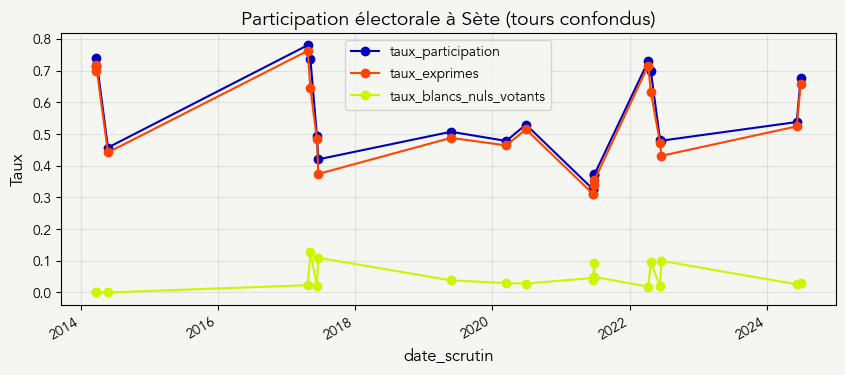

In [24]:
# A garder pour rapport
ax = (
    city_event
    .set_index("date_scrutin")
    [["taux_participation", "taux_exprimes", "taux_blancs_nuls_votants"]]
    .plot(kind="line", figsize=(10, 4), marker="o", color=COLOR_PALETTE)
)
ax.set_title("Participation électorale à Sète (tours confondus)")
ax.set_ylabel("Taux")
ax.grid(True, alpha=0.3)
save_fig("Participation électorale à Sète (tours confondus)")
plt.show()


Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Participation moyenne par type de scrutin.png


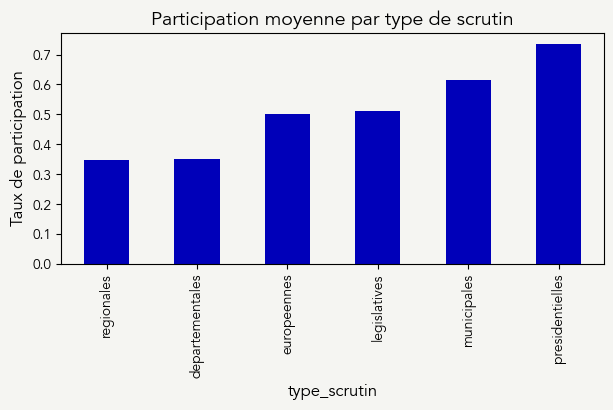

In [25]:
city_by_type = (
    city_event
    .groupby("type_scrutin", as_index=False)["taux_participation"]
    .mean()
    .sort_values("taux_participation")
)
ax = city_by_type.plot(kind="bar", x="type_scrutin", y="taux_participation", figsize=(7, 3), color=COLOR_PRIMARY, legend=False)
ax.set_title("Participation moyenne par type de scrutin")
ax.set_ylabel("Taux de participation")
save_fig("Participation moyenne par type de scrutin")
plt.show()


In [26]:
latest_event = city_event.sort_values("date_scrutin").iloc[-1]
focus_mask = (
    (base_bv["type_scrutin"] == latest_event["type_scrutin"]) &
    (base_bv["date_scrutin"] == latest_event["date_scrutin"]) &
    (base_bv["tour"] == latest_event["tour"])
)

base_focus = base_bv[focus_mask].copy()
base_focus = base_focus.sort_values("taux_participation")

print("Bureaux a plus faible participation (dernier scrutin):")
base_focus[["code_bv", "taux_participation"]].head(10)

# bureaux a plus forte participation (dernier scrutin) à faire au format graphique


Bureaux a plus faible participation (dernier scrutin):


code_bv  taux_participation
519  343010026            0.446295
479  343010024            0.591334
359  343010018            0.599529
379  343010019            0.599792
399  343010020            0.632323
79   343010004            0.633855
559  343010028            0.647558
119  343010006            0.650415
179  343010009            0.654497
199  343010010            0.661934

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Participation vs blancs - nuls (dernier scrutin).png


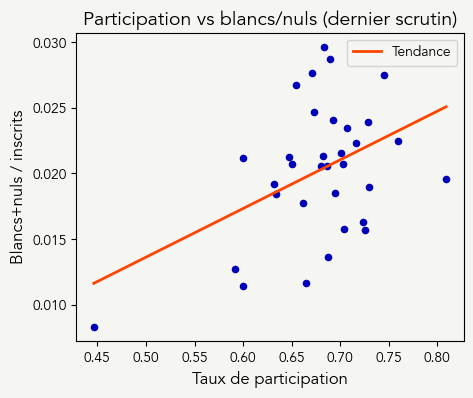

In [27]:
base_latest = base_bv[
    (base_bv["type_scrutin"] == latest_event["type_scrutin"])
    & (base_bv["tour"] == latest_event["tour"])
    & (base_bv["date_scrutin"] == latest_event["date_scrutin"])
].copy()

ax = base_latest.plot.scatter(
    x="taux_participation",
    y="taux_blancs_nuls_inscrits",
    figsize=(5, 4),
    color=COLOR_PRIMARY,
)

valid = base_latest[["taux_participation", "taux_blancs_nuls_inscrits"]].dropna()
if len(valid) >= 2:
    coef = np.polyfit(valid["taux_participation"], valid["taux_blancs_nuls_inscrits"], 1)
    x_vals = np.linspace(valid["taux_participation"].min(), valid["taux_participation"].max(), 100)
    y_vals = coef[0] * x_vals + coef[1]
    ax.plot(x_vals, y_vals, color=COLOR_SECONDARY, linewidth=2, label="Tendance")
    ax.legend()

ax.set_title("Participation vs blancs/nuls (dernier scrutin)")
ax.set_xlabel("Taux de participation")
ax.set_ylabel("Blancs+nuls / inscrits")
save_fig("Participation vs blancs - nuls (dernier scrutin)")
plt.show()


## 7) Structure du vote par blocs


Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Parts par blocs (exprimes) - Sète.png


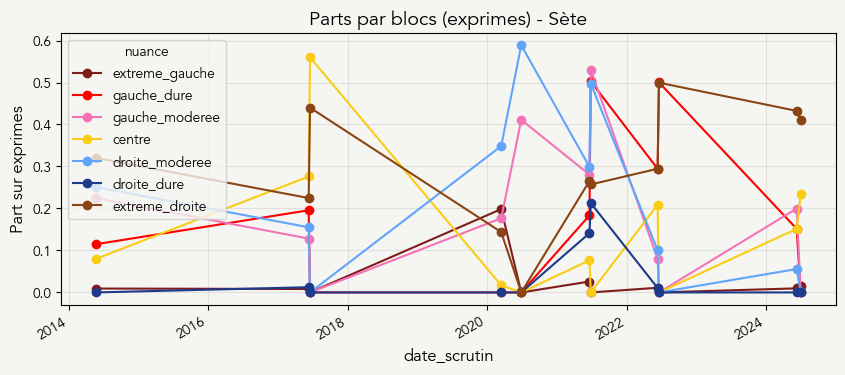

In [28]:
bloc_city = (
    bloc_bv
    .groupby(["date_scrutin", "type_scrutin", "tour", "annee", "bloc_1_final"], as_index=False)
    .agg({"voix": "sum", "exprimes": "sum", "inscrits": "sum"})
    .sort_values("date_scrutin")
)

bloc_city["part_bloc_exprimes"] = bloc_city["voix"] / bloc_city["exprimes"].replace(0, np.nan)
bloc_city["part_bloc_inscrits"] = bloc_city["voix"] / bloc_city["inscrits"].replace(0, np.nan)

bloc_city_nuance = bloc_city.copy()
bloc_city_nuance["nuance"] = (
    bloc_city_nuance["bloc_1_final"].map(NUANCE_MAP).fillna(bloc_city_nuance["bloc_1_final"])
)
bloc_city_nuance = bloc_city_nuance[bloc_city_nuance["nuance"].isin(ALLOWED_NUANCES)].copy()

bloc_city_nuance = (
    bloc_city_nuance
    .groupby(["date_scrutin", "type_scrutin", "tour", "annee", "nuance"], as_index=False)
    .agg({"voix": "sum", "exprimes": "sum", "inscrits": "sum"})
    .sort_values("date_scrutin")
)

bloc_city_nuance["part_bloc_exprimes"] = bloc_city_nuance["voix"] / bloc_city_nuance["exprimes"].replace(0, np.nan)
bloc_city_nuance["part_bloc_inscrits"] = bloc_city_nuance["voix"] / bloc_city_nuance["inscrits"].replace(0, np.nan)

pivot_bloc = bloc_city_nuance.pivot_table(
    index="date_scrutin",
    columns="nuance",
    values="part_bloc_exprimes",
)

pivot_bloc = pivot_bloc.reindex(columns=ALLOWED_NUANCES).fillna(0)

ax = pivot_bloc.plot(figsize=(10, 4), marker="o", color=nuance_colors_for(pivot_bloc.columns))
ax.set_title("Parts par blocs (exprimes) - Sète")
ax.set_ylabel("Part sur exprimes")
ax.grid(True, alpha=0.3)
save_fig("Parts par blocs (exprimes) - Sète")
plt.show()


## 7b) Evolution historique des nuances politiques (7 categories)


nuance    bloc_1_final code_candidature_raw                                    nom_candidature     voix
27           centre          centre                  REM                                   Christophe EUZET  10745.0
98   gauche_moderee   gauche_modere                 LUGE            L'Occitanie en Commun avec Carole DELGA   9835.0
57   extreme_droite  extreme_droite                   RN                             Aurélien LOPEZ-LIGUORI   9057.0
73      gauche_dure     gauche_dure               BC-COM                                  Binome communiste   8884.0
31   droite_moderee   droite_modere               BC-DVD                               Binome divers droite   8588.0
47   extreme_droite  extreme_droite                   FN                                      Myriam ROQUES   8561.0
36   droite_moderee   droite_modere                 LDVD  Liste de rassemblement Républicain : Sète comm...   8033.0
0             autre           autre                   UG                                     Gabriel BLASCO   7534.0
80      gauche_dure     gauche_dure                  NUP                                             BLASCO   7236.0
58   extreme_droite  extreme_droite                   RN                                      LOPEZ LIGUORI   7224.0
95   gauche_moderee   gauche_modere                  LUG                                ENSEMBLE POUR SÈTE!   7011.0
53   extreme_droite  extreme_droite                  LRN  LA FRANCE REVIENT ! AVEC JORDAN BARDELLA ET MA...   6245.0
54   extreme_droite  extreme_droite                  LRN                             Rassembler l'Occitanie   5661.0
37   droite_moderee   droite_modere                 LDVD  Liste de rassemblement Rï¿½publicain : Sï¿½te ...   5364.0
4            centre          centre                  ENS                                  Jocelyne GIZARDIN   5147.0
81      gauche_dure     gauche_dure                  NUP                                     Gabriel BLASCO   4664.0
51   extreme_droite  extreme_droite                  LFN                                        Louis ALIOT   4439.0
30      droite_dure     droite_dure                  LUD                       Du courage pour l'Occitanie!   3904.0
56   extreme_droite  extreme_droite                   RN                             Aurélien LOPEZ LIGUORI   3659.0
3            centre          centre                  ENS                                   Christophe EUZET   3303.0
64   extreme_gauche  extreme_gauche                 LEXG                                ALTERNATIVE SETOISE   2961.0
43   droite_moderee   droite_modere                 LUMP                               Mich�le ALLIOT-MARIE   2767.0
44   extreme_droite  extreme_droite                BC-RN                      Binome rassemblement national   2721.0
90   gauche_moderee   gauche_modere                 LDVG                               VIVEMENT SETE DEMAIN   2718.0
96   gauche_moderee   gauche_modere                  LUG                                 RÉVEILLER L'EUROPE   2380.0
42   droite_moderee   droite_modere                   LR                                     Laurence MAGNE   2362.0
50   extreme_droite  extreme_droite                 LEXD                                 Sï¿½bastien PACULL   2213.0
23           centre          centre                 LENS                                    BESOIN D'EUROPE   2151.0
40   droite_moderee   droite_modere                 LDVD                  UNION DES DROITES ET DES CITOYENS   2013.0
78      gauche_dure     gauche_dure                  LFI              LA FRANCE INSOUMISE - UNION POPULAIRE   1906.0
101  gauche_moderee   gauche_modere                  SOC                                 Sï¿½bastien DENAJA   1828.0
77      gauche_dure     gauche_dure                  LFG                                 Jean-Luc MELENCHON   1594.0
33   droite_moderee   droite_modere                  DVD                                        Yves MICHEL   1592.0
75      gauche_dure     gauche_dure

nuance bloc_1_final code_candidature_raw nom_candidature    voix
0  autre        autre                   UG  Gabriel BLASCO  7534.0

Nuances hors liste (exclues): ['autre']
Couverture min (nuances mappees / exprimes): 0.37832699619771865


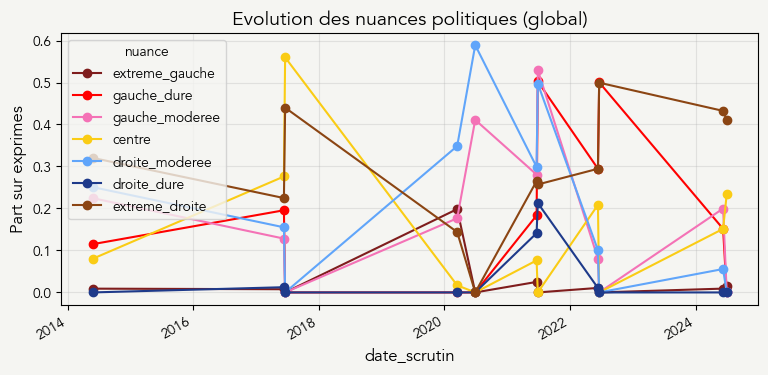

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0001.png


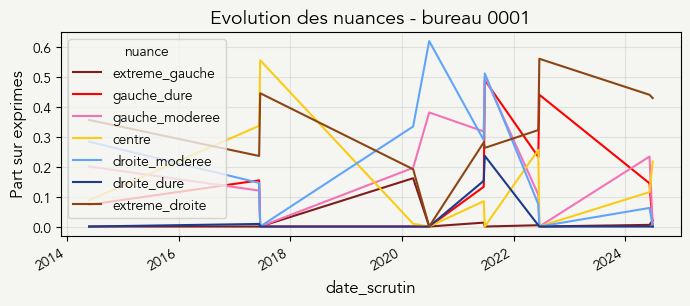

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0002.png


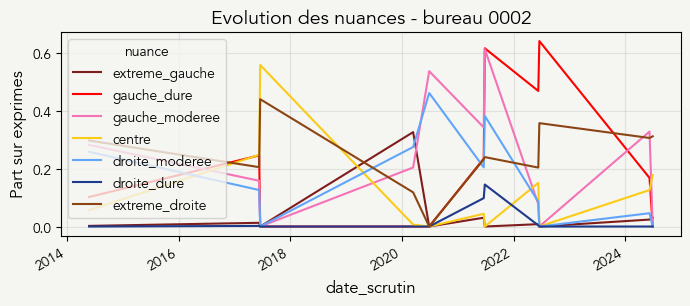

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0003.png


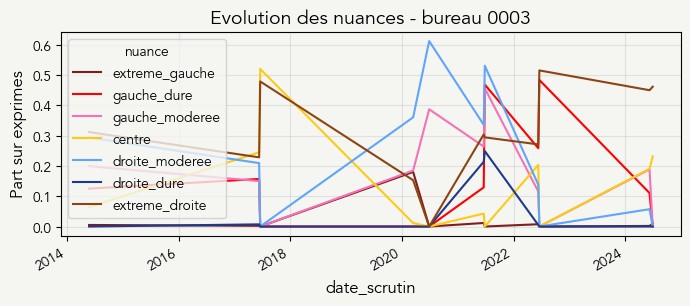

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0004.png


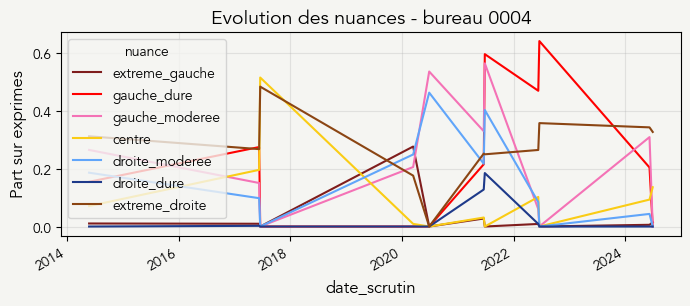

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0005.png


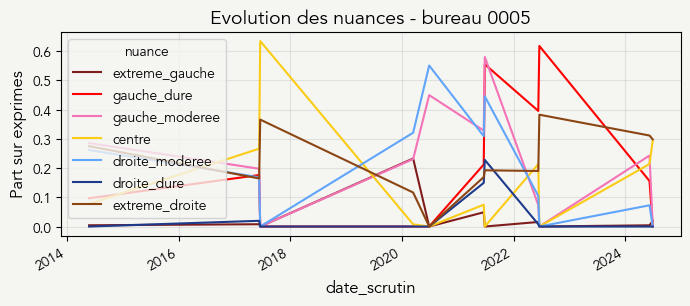

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0006.png


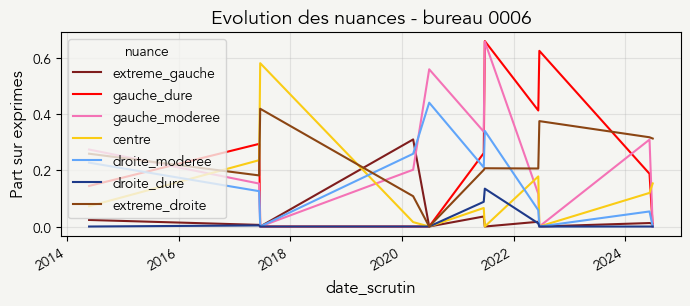

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0007.png


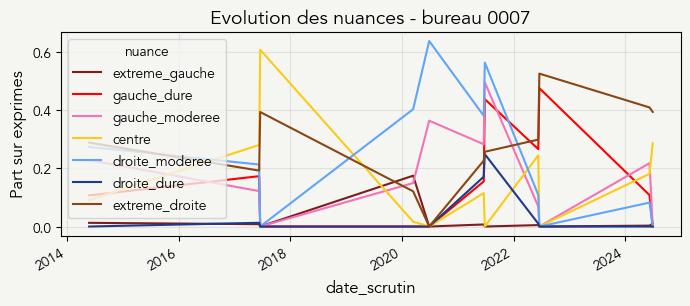

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0008.png


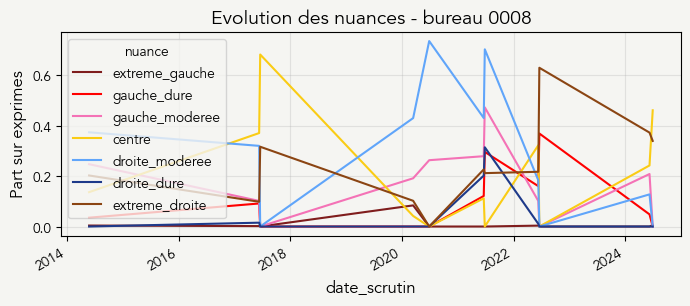

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0009.png


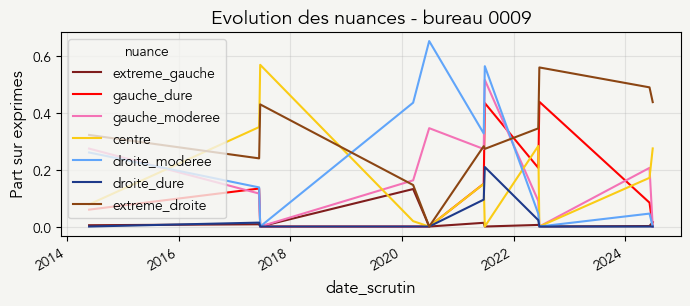

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0010.png


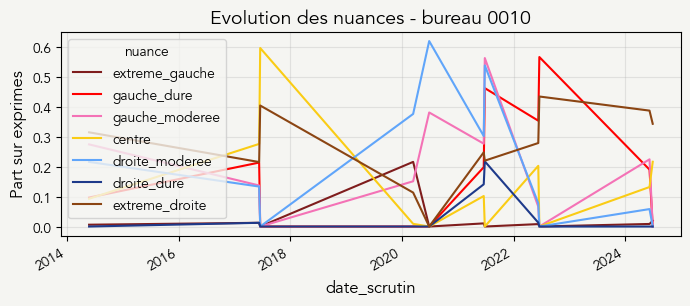

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0011.png


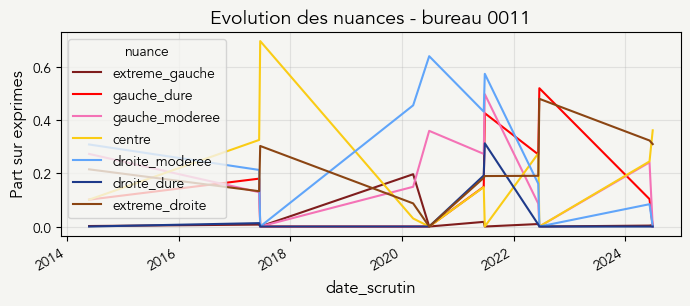

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0012.png


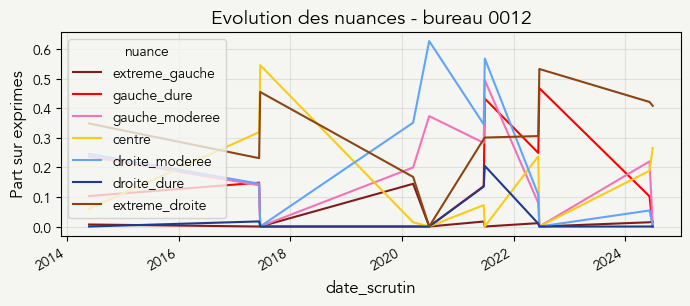

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0013.png


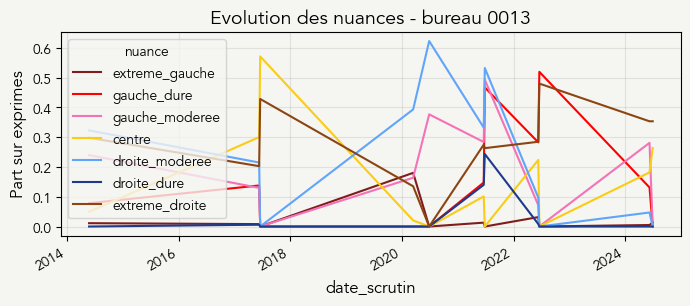

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0014.png


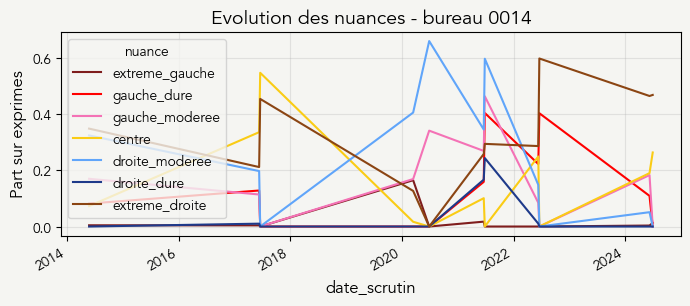

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0015.png


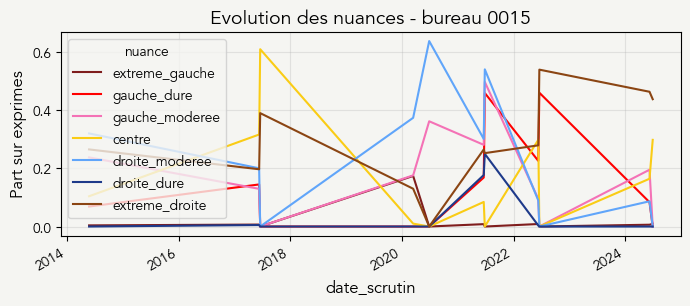

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0016.png


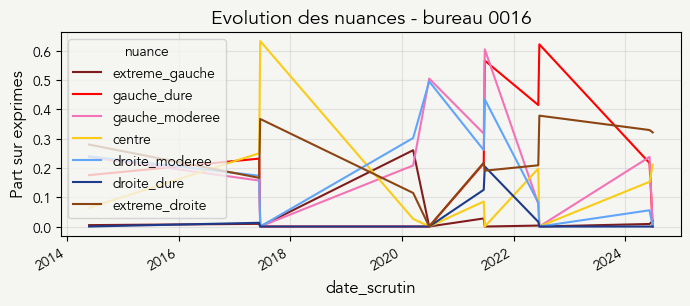

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0017.png


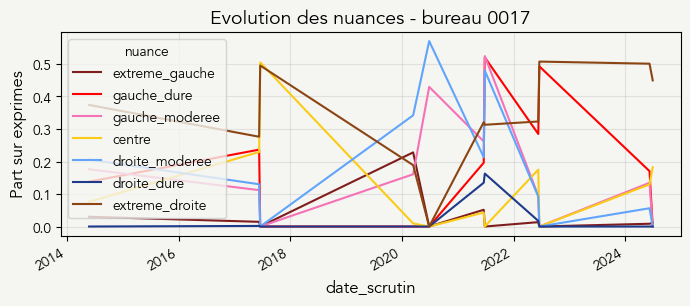

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0018.png


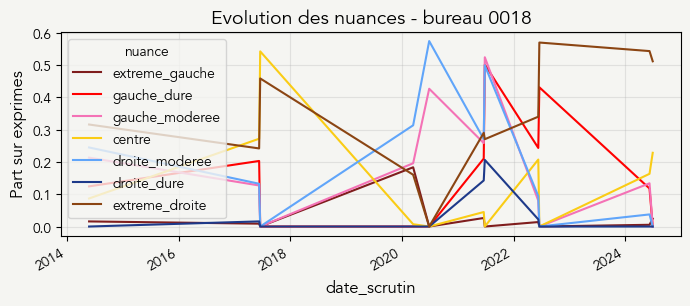

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0019.png


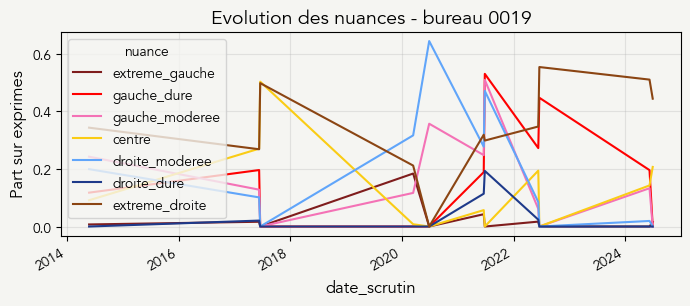

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0020.png


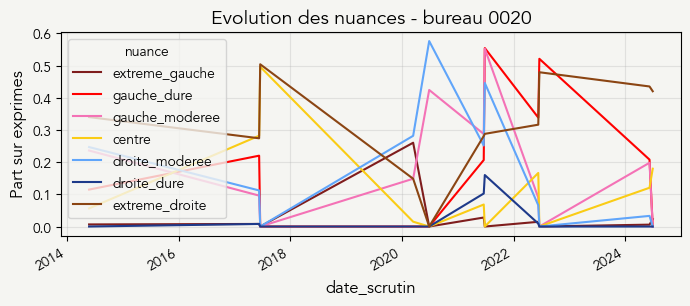

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0021.png


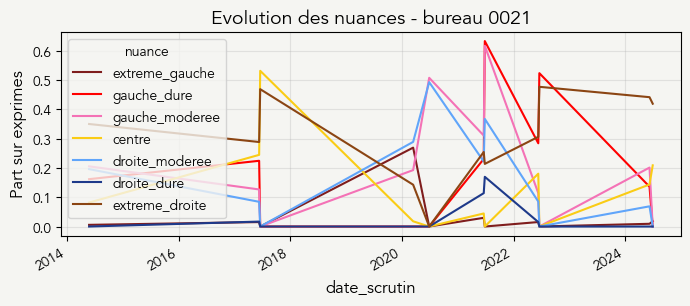

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0022.png


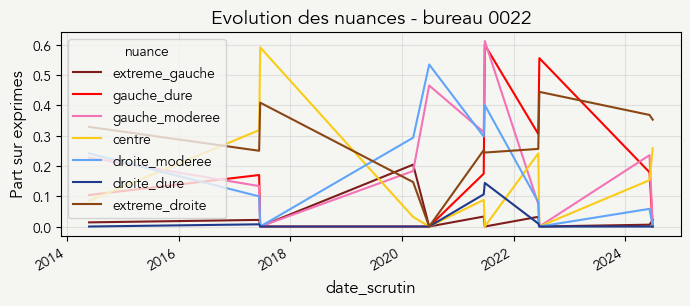

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0023.png


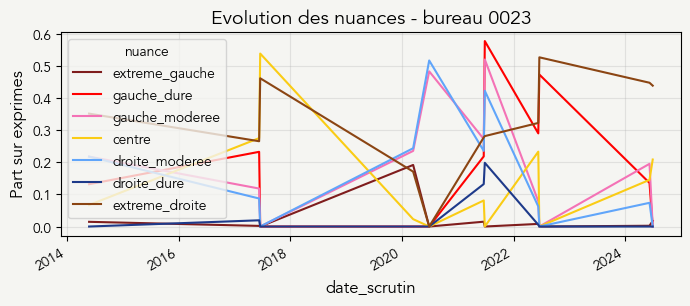

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0024.png


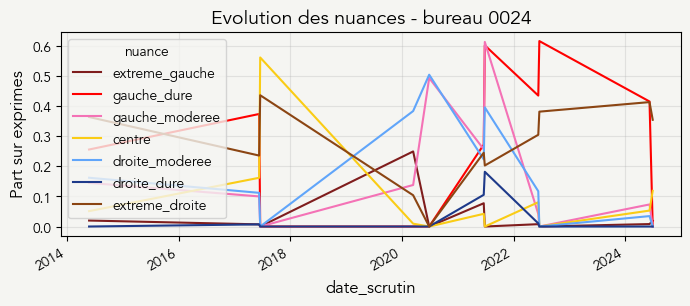

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0025.png


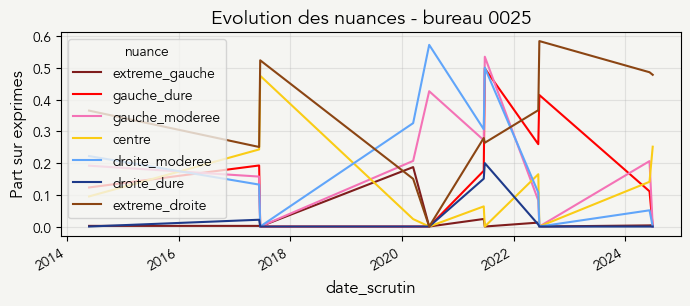

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0026.png


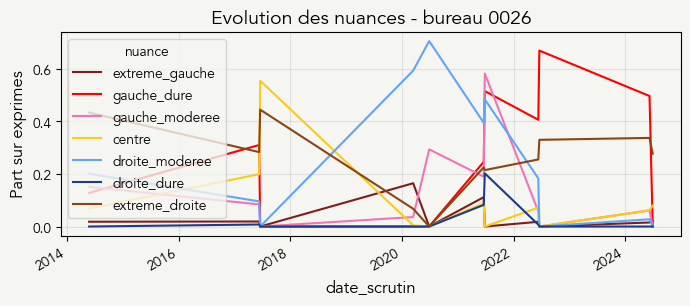

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0027.png


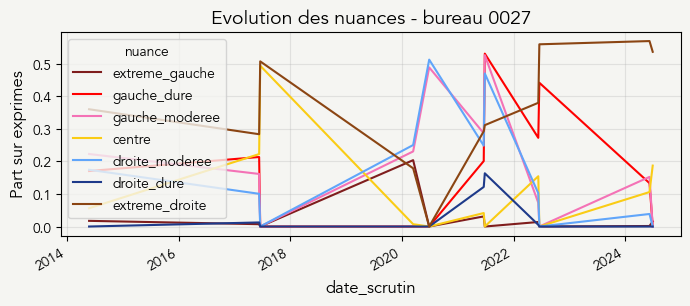

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0028.png


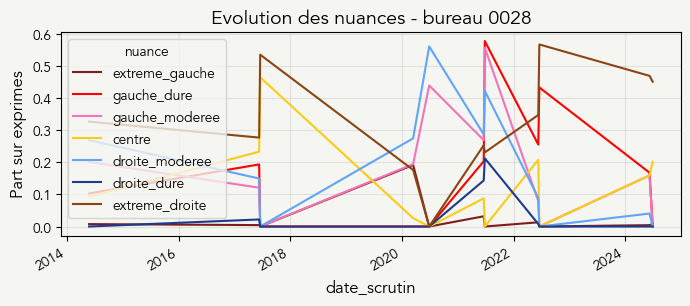

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0029.png


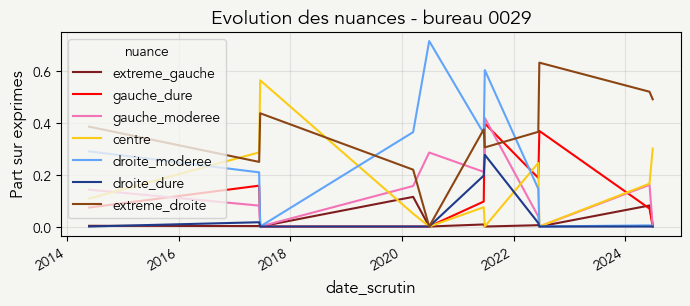

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0030.png


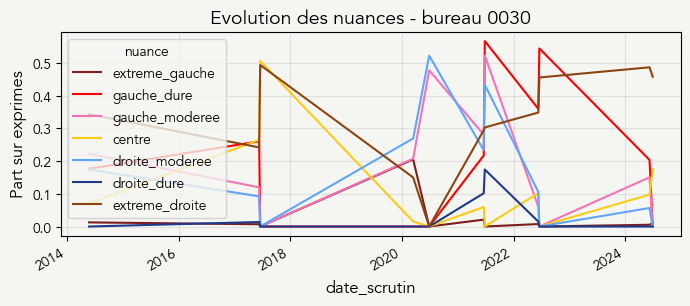

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0031.png


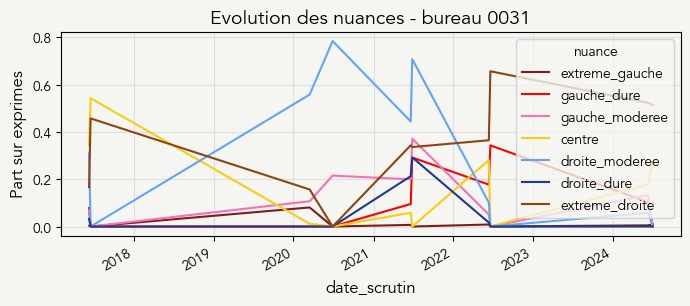

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0032.png


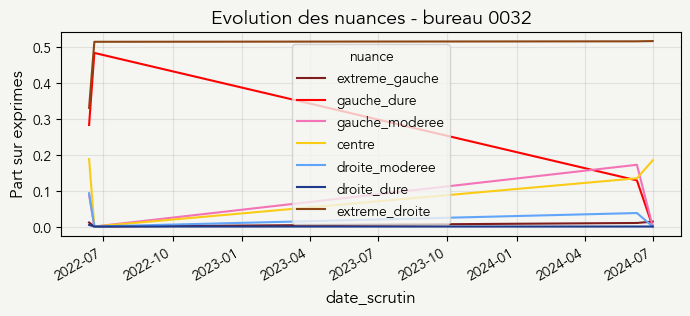

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Evolution des nuances - bureau 0033.png


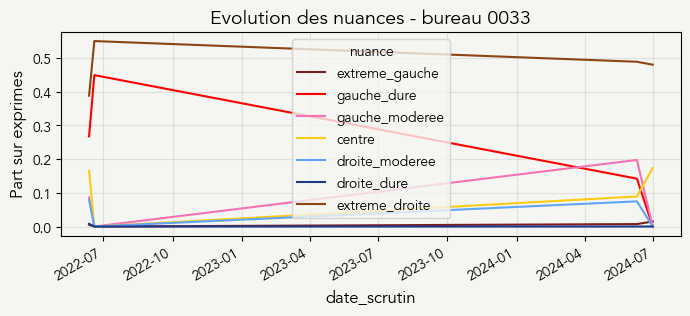

In [29]:
# A garder

# Evolution historique des nuances politiques (7 categories)
NUANCE_TYPE_FILTER = CONFIG.get("nuance_type_filter")

allowed_nuances = ALLOWED_NUANCES

from IPython.display import display

NUANCE_COLORS = {
    "extreme_gauche": "#7f1d1d",
    "gauche_dure": "#ff0000",
    "gauche_moderee": "#f472b6",
    "centre": "#facc15",
    "droite_moderee": "#60a5fa",
    "droite_dure": "#1e3a8a",
    "extreme_droite": "#8b4513",
}

def nuance_colors_for(cols: list[str]) -> list[str]:
    return [NUANCE_COLORS.get(c, COLOR_PRIMARY) for c in cols]

nuance_map = NUANCE_MAP

nuance_series = candidates_long.copy()
if NUANCE_TYPE_FILTER:
    nuance_series = nuance_series[nuance_series["type_scrutin"] == NUANCE_TYPE_FILTER]

if CONFIG["constant_perimeter"]:
    nuance_series = nuance_series[nuance_series["code_bv"].isin(CONSTANT_BV_CODES)].copy()

base_nuance = nuance_series["bloc_1_final"].astype(str).str.strip().str.lower()
nuance_series["nuance"] = base_nuance.map(nuance_map).fillna(base_nuance)

# Controle: tableau des nuances (candidats + codes)
nuance_control = (
    nuance_series
    .groupby(
        ["nuance", "bloc_1_final", "code_candidature_raw", "nom_candidature"],
        as_index=False,
    )
    .agg({"voix": "sum"})
    .sort_values("voix", ascending=False)
)
display(nuance_control.head(50))

nuance_unknown = nuance_control[~nuance_control["nuance"].isin(allowed_nuances)]
display(nuance_unknown.head(50))

unknown = sorted(set(nuance_series["nuance"].dropna()) - set(allowed_nuances))
if unknown:
    print(f"Nuances hors liste (exclues): {unknown}")

nuance_series = nuance_series[nuance_series["nuance"].isin(allowed_nuances)].copy()

nuance_series = (
    nuance_series
    .groupby(
        [
            "code_bv",
            "bureau",
            "date_scrutin",
            "type_scrutin",
            "tour",
            "nuance",
        ],
        as_index=False,
    )
    .agg({"voix": "sum"})
)

exprimes_bv = base_bv[["code_bv", "date_scrutin", "type_scrutin", "tour", "exprimes"]].copy()
nuance_series = nuance_series.merge(exprimes_bv, on=["code_bv", "date_scrutin", "type_scrutin", "tour"], how="left")
nuance_series["part_exprimes"] = nuance_series["voix"] / nuance_series["exprimes"].replace(0, np.nan)

# Couverture des votes (nuances mappees / exprimes)
coverage = (
    nuance_series
    .groupby(["code_bv", "date_scrutin", "type_scrutin", "tour"], as_index=False)
    .agg({"voix": "sum", "exprimes": "first"})
)
coverage["taux_couverture"] = coverage["voix"] / coverage["exprimes"].replace(0, np.nan)
print("Couverture min (nuances mappees / exprimes):", coverage["taux_couverture"].min())

exprimes_city = (
    base_bv
    .groupby(["date_scrutin", "type_scrutin", "tour"], as_index=False)["exprimes"]
    .sum()
)

nuance_global = (
    nuance_series
    .groupby(["date_scrutin", "type_scrutin", "tour", "nuance"], as_index=False)
    .agg({"voix": "sum"})
)
nuance_global = nuance_global.merge(exprimes_city, on=["date_scrutin", "type_scrutin", "tour"], how="left")
nuance_global["part_exprimes"] = nuance_global["voix"] / nuance_global["exprimes"].replace(0, np.nan)

# Graphique global (ville)
plot_global = nuance_global.copy()
if not plot_global.empty:
    pivot = plot_global.pivot_table(
        index="date_scrutin",
        columns="nuance",
        values="part_exprimes",
    )
    pivot = pivot.reindex(columns=allowed_nuances).fillna(0)
    ax = pivot.plot(figsize=(9, 4), marker="o", color=nuance_colors_for(pivot.columns))
    ax.set_title("Evolution des nuances politiques (global)")
    ax.set_ylabel("Part sur exprimes")
    ax.grid(True, alpha=0.3)
    plt.show()

# Un graphique par bureau
bureaux = sorted(nuance_series["bureau"].dropna().unique())
for bureau in bureaux:
    sub = nuance_series[nuance_series["bureau"] == bureau]
    if sub.empty:
        continue
    pivot_bv = sub.pivot_table(
        index="date_scrutin",
        columns="nuance",
        values="part_exprimes",
    )
    pivot_bv = pivot_bv.reindex(columns=allowed_nuances).fillna(0)
    ax = pivot_bv.plot(figsize=(8, 3), color=nuance_colors_for(pivot_bv.columns))
    ax.set_title(f"Evolution des nuances - bureau {bureau}")
    ax.set_ylabel("Part sur exprimes")
    ax.grid(True, alpha=0.3)
    save_fig(f"Evolution des nuances - bureau {bureau}")
    plt.show()


Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Parts par blocs (exprimes) - legislatives 2024-06-30.png


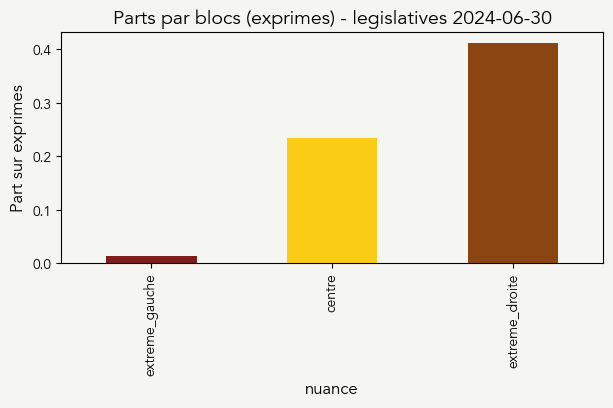

In [30]:
bloc_focus = bloc_city_nuance[
    (bloc_city_nuance["type_scrutin"] == CONFIG["focus_type"])
    & (bloc_city_nuance["tour"] == CONFIG["focus_tour"])
].copy()

if not bloc_focus.empty:
    latest_bloc_date = bloc_focus["date_scrutin"].max()
    latest_bloc = bloc_focus[bloc_focus["date_scrutin"] == latest_bloc_date].sort_values("part_bloc_exprimes")
    colors = [NUANCE_COLORS.get(n, COLOR_PRIMARY) for n in latest_bloc["nuance"]]
    ax = latest_bloc.plot.bar(
        x="nuance",
        y="part_bloc_exprimes",
        figsize=(7, 3),
        color=colors,
        legend=False,
    )
    ax.set_title(f"Parts par blocs (exprimes) - {CONFIG['focus_type']} {latest_bloc_date.date()}")
    ax.set_ylabel("Part sur exprimes")
    save_fig(f"Parts par blocs (exprimes) - {CONFIG['focus_type']} {latest_bloc_date.date()}")
    plt.show()


In [31]:
if CONFIG["save_interim"]:
    INTERIM_DIR.mkdir(parents=True, exist_ok=True)
    base_bv.to_parquet(INTERIM_DIR / "base_bv_sete.parquet", index=False)
    bloc_bv.to_parquet(INTERIM_DIR / "bloc_bv_sete.parquet", index=False)
    bloc_city.to_parquet(INTERIM_DIR / "bloc_city_sete.parquet", index=False)



----------Muncipales 2020----------

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Distribution des scores par bureau - extreme_gauche (municipales 2020, tour 1).png


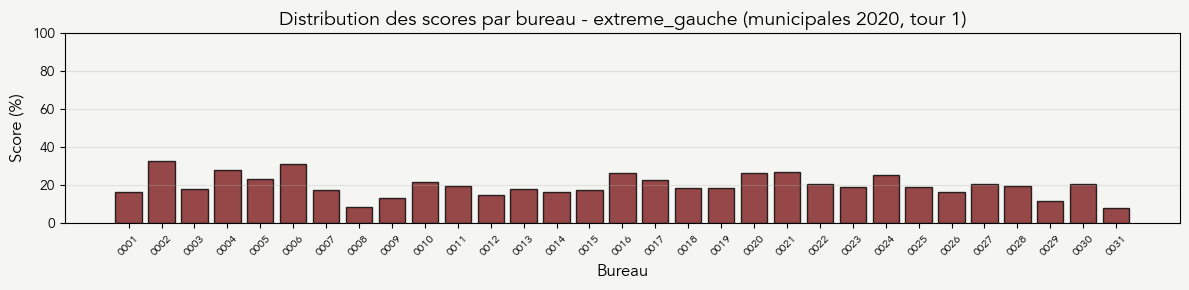

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Distribution des scores par bureau - gauche_moderee (municipales 2020, tour 1).png


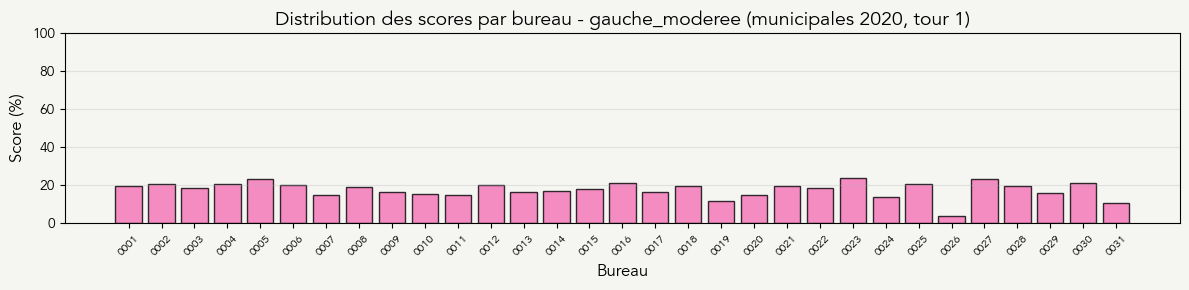

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Distribution des scores par bureau - centre (municipales 2020, tour 1).png


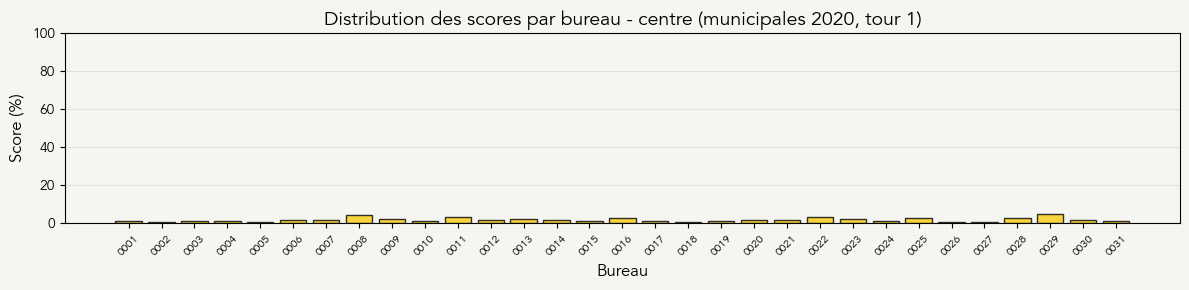

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Distribution des scores par bureau - droite_moderee (municipales 2020, tour 1).png


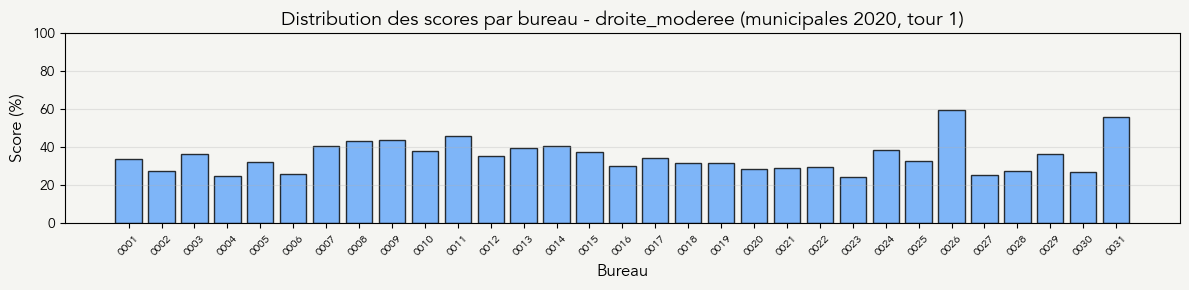

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Distribution des scores par bureau - extreme_droite (municipales 2020, tour 1).png


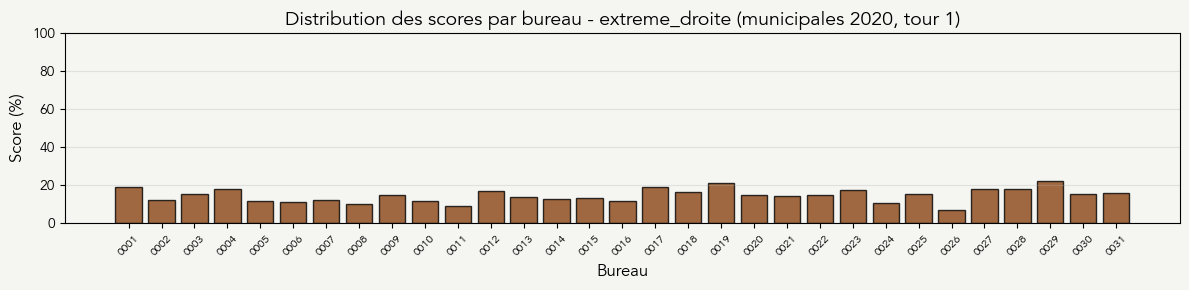


----------Léglistatives 2022----------

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Distribution des scores par bureau - extreme_gauche (legislatives 2022, tour 1).png


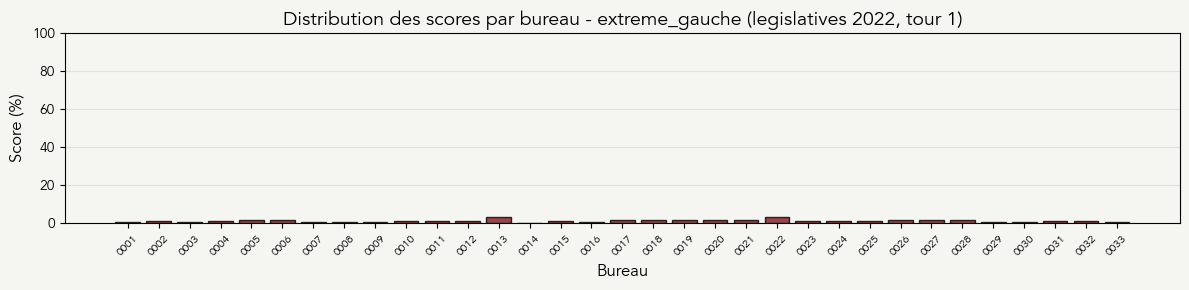

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Distribution des scores par bureau - gauche_dure (legislatives 2022, tour 1).png


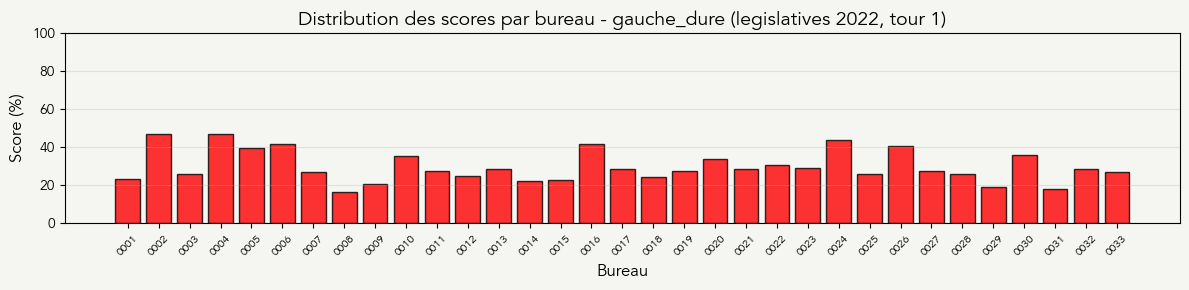

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Distribution des scores par bureau - gauche_moderee (legislatives 2022, tour 1).png


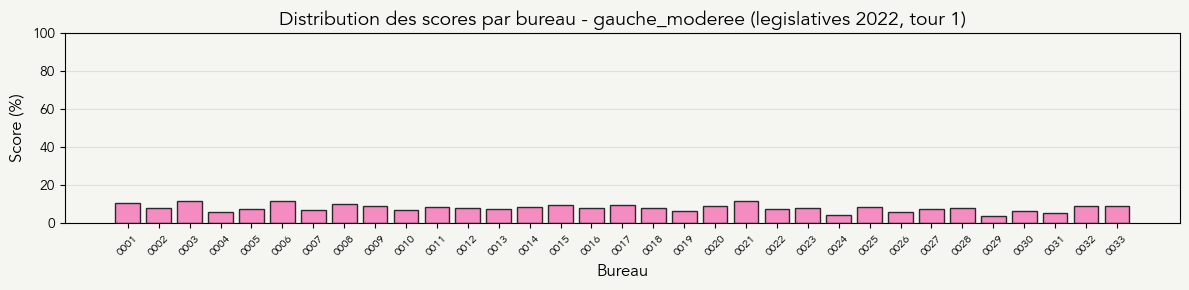

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Distribution des scores par bureau - centre (legislatives 2022, tour 1).png


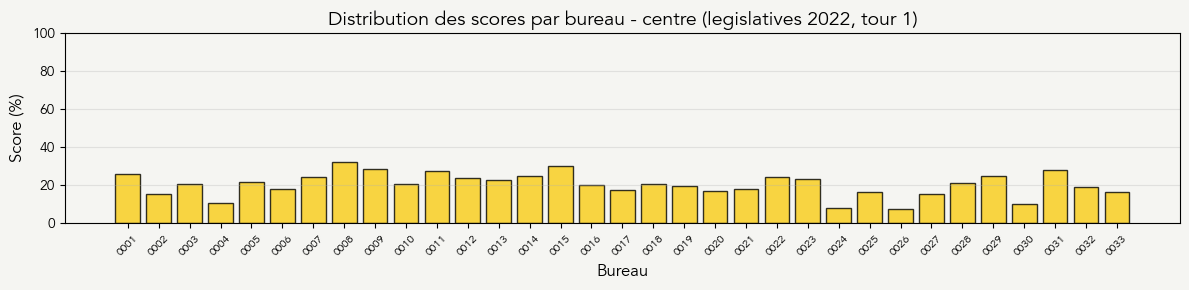

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Distribution des scores par bureau - droite_moderee (legislatives 2022, tour 1).png


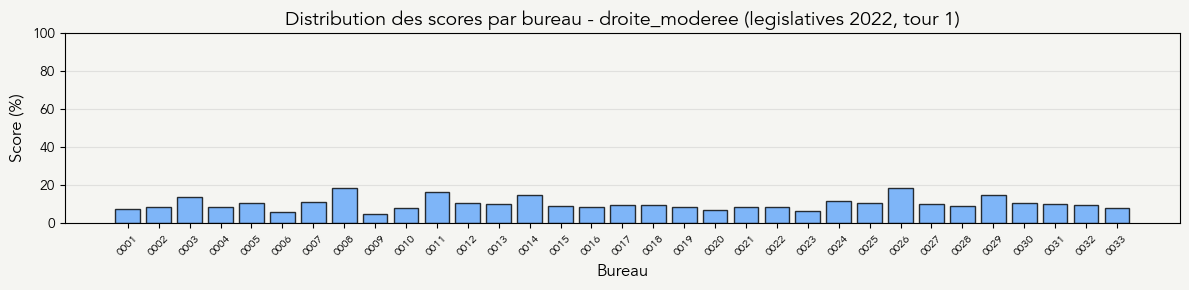

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Distribution des scores par bureau - droite_dure (legislatives 2022, tour 1).png


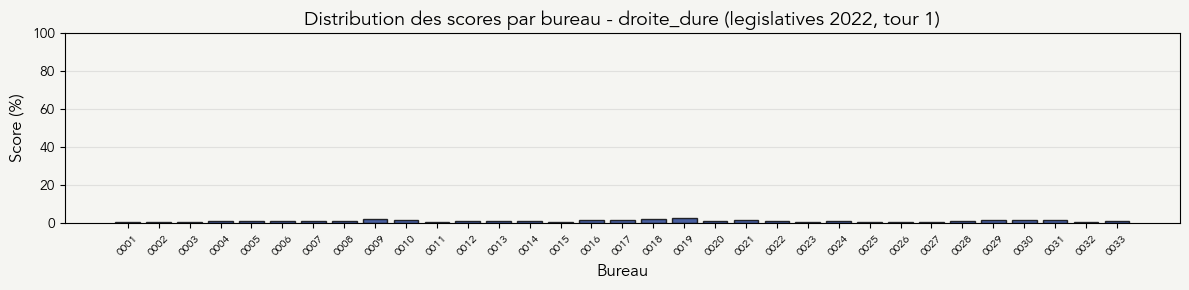

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Distribution des scores par bureau - extreme_droite (legislatives 2022, tour 1).png


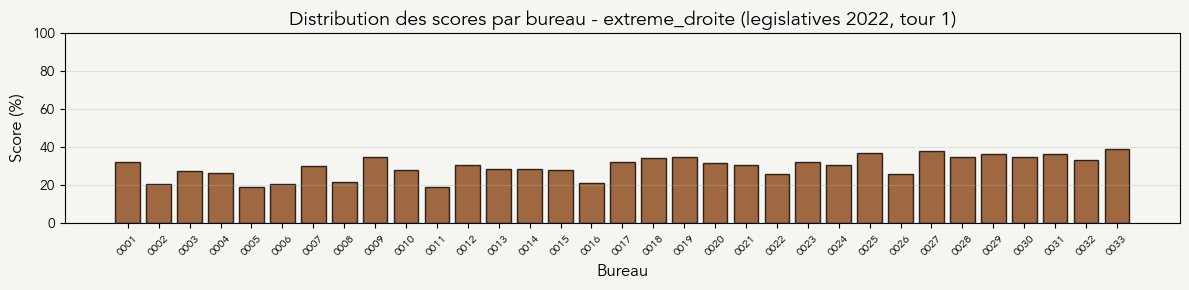

In [32]:
def plot_scores_by_bureau(
    nuance_df: pd.DataFrame,
    type_scrutin: str,
    year: int,
    tour: int | None = None,
) -> None:
    focus = nuance_df[
        nuance_df["type_scrutin"] == type_scrutin
    ].copy()

    focus = focus[focus["date_scrutin"].dt.year == year].copy()

    if focus.empty:
        print(f"Aucune donnee pour {type_scrutin} {year}.")
        return

    if tour is not None:
        focus = focus[focus["tour"] == tour].copy()
    else:
        tours = sorted(focus["tour"].dropna().unique())
        if not tours:
            print(f"Aucun tour disponible pour {type_scrutin} {year}.")
            return
        if len(tours) > 1:
            print(f"Plusieurs tours disponibles pour {type_scrutin} {year}: {tours}. Tour {tours[0]} utilise.")
        tour = int(tours[0])
        focus = focus[focus["tour"] == tour].copy()

    if focus.empty:
        print(f"Aucune donnee pour {type_scrutin} {year} (tour {tour}).")
        return

    focus_date = focus["date_scrutin"].max()
    focus = focus[focus["date_scrutin"] == focus_date].copy()
    focus["score"] = focus["part_exprimes"] * 100

    scores_by_bureau = (
        focus.pivot_table(index="bureau", columns="nuance", values="score", aggfunc="sum")
        .reindex(columns=allowed_nuances)
        .fillna(0)
        .reset_index()
    )

    scores_by_bureau["bureau_num"] = pd.to_numeric(scores_by_bureau["bureau"], errors="coerce")
    scores_by_bureau = scores_by_bureau.sort_values(["bureau_num", "bureau"]).drop(columns="bureau_num")

    present_nuances = set(focus["nuance"].dropna().unique())
    nuances = [n for n in allowed_nuances if n in present_nuances]

    for nuance in nuances:
        fig, ax = plt.subplots(figsize=(12, 3))
        ax.bar(
            scores_by_bureau["bureau"].astype(str),
            scores_by_bureau[nuance],
            color=NUANCE_COLORS.get(nuance, COLOR_PRIMARY),
            edgecolor="black",
            alpha=0.8,
        )
        ax.set_title(
            f"Distribution des scores par bureau - {nuance} ({type_scrutin} {year}, tour {tour})"
        )
        ax.set_xlabel("Bureau")
        ax.set_ylabel("Score (%)")
        ax.set_ylim(0, 100)
        ax.grid(axis="y", alpha=0.3)
        ax.tick_params(axis="x", labelrotation=45, labelsize=8)
        plt.tight_layout()
        save_fig(f"Distribution des scores par bureau - {nuance} ({type_scrutin} {year}, tour {tour})")
        plt.show()

print("\n----------Muncipales 2020----------\n")
plot_scores_by_bureau(nuance_series, "municipales", 2020, 1)
print("\n----------Léglistatives 2022----------\n")
plot_scores_by_bureau(nuance_series, "legislatives", 2022, 1) 


Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Nuance en tête par bureau - legislatives 2022, tour 1.png


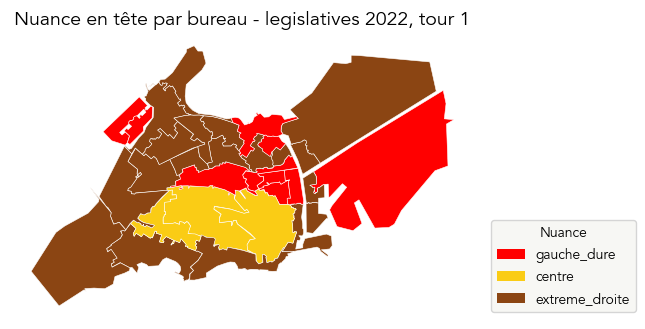

In [33]:
# Carte geopandas - nuance en tete (legislatives 2022, tour 1)
GEO_PATH = DATA_DIR / "geo" / "bdv_s_te.geojson"

import geopandas as gpd
from matplotlib.patches import Patch

gdf = gpd.read_file(GEO_PATH)
gdf["bureau"] = gdf["name"].astype(str).str.extract(r"(\d+)").fillna("0")[0].str.zfill(4)

focus_map = nuance_series[
    (nuance_series["type_scrutin"] == "legislatives")
    & (nuance_series["tour"] == 1)
].copy()

focus_map = focus_map[focus_map["date_scrutin"].dt.year == 2022].copy()

if focus_map.empty:
    print("Aucune donnee pour legislatives 2022 (tour 1).")
else:
    focus_date = focus_map["date_scrutin"].max()
    focus_map = focus_map[focus_map["date_scrutin"] == focus_date].copy()

    winners = (
        focus_map
        .sort_values(["bureau", "part_exprimes"], ascending=[True, False])
        .dropna(subset=["bureau", "nuance"])
        .drop_duplicates(subset=["bureau"])
    )
    winners["nuance_leader"] = winners["nuance"]
    winners["color"] = winners["nuance_leader"].map(NUANCE_COLORS).fillna(COLOR_PRIMARY)

    map_df = gdf.merge(
        winners[["bureau", "nuance_leader", "color"]],
        on="bureau",
        how="left",
    )

    ax = map_df.plot(color=map_df["color"], edgecolor="white", linewidth=0.4, figsize=(6, 6))
    ax.set_facecolor("white")
    ax.figure.set_facecolor("white")
    ax.set_title("Nuance en tête par bureau - legislatives 2022, tour 1")
    ax.set_axis_off()

    present = [n for n in ALLOWED_NUANCES if n in winners["nuance_leader"].unique()]
    handles = [Patch(facecolor=NUANCE_COLORS.get(n, COLOR_PRIMARY), label=n) for n in present]
    if handles:
        ax.legend(handles=handles, title="Nuance", loc="lower left", bbox_to_anchor=(1.02, 0))

    save_fig("Nuance en tête par bureau - legislatives 2022, tour 1")
    plt.show()


Bureaux sans geometrie (municipales 2020): ['0004']
Bureaux sans donnees (municipales 2020): ['0032', '0033']
Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Nuance en tête par bureau - municipales 2020, tour 1.png


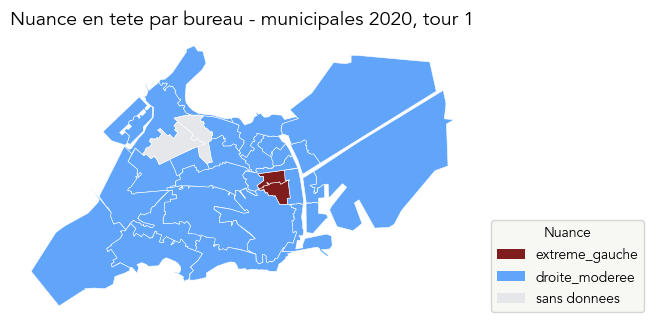

In [34]:
# Carte geopandas - nuance en tete (municipales 2020, tour 1)
GEO_PATH = DATA_DIR / "geo" / "bdv_s_te.geojson"

import geopandas as gpd
from matplotlib.patches import Patch

gdf = gpd.read_file(GEO_PATH)
gdf["bureau"] = gdf["name"].astype(str).str.extract(r"(\d+)").fillna("0")[0].str.zfill(4)

focus_map = nuance_series[
    (nuance_series["type_scrutin"] == "municipales")
    & (nuance_series["tour"] == 1)
].copy()

focus_map = focus_map[focus_map["date_scrutin"].dt.year == 2020].copy()

if focus_map.empty:
    print("Aucune donnee pour municipales 2020 (tour 1).")
else:
    focus_date = focus_map["date_scrutin"].max()
    focus_map = focus_map[focus_map["date_scrutin"] == focus_date].copy()

    winners = (
        focus_map
        .sort_values(["bureau", "part_exprimes"], ascending=[True, False])
        .dropna(subset=["bureau", "nuance"])
        .drop_duplicates(subset=["bureau"])
    )
    winners["nuance_leader"] = winners["nuance"]
    winners["color"] = winners["nuance_leader"].map(NUANCE_COLORS)

    map_df = gdf.merge(
        winners[["bureau", "nuance_leader", "color"]],
        on="bureau",
        how="left",
    )

    missing_in_geo = sorted(set(winners["bureau"]) - set(gdf["bureau"]))
    missing_in_data = sorted(set(gdf["bureau"]) - set(winners["bureau"]))
    if missing_in_geo:
        print(f"Bureaux sans geometrie (municipales 2020): {missing_in_geo}")
    if missing_in_data:
        print(f"Bureaux sans donnees (municipales 2020): {missing_in_data}")

    missing_color = "#e5e7eb"
    map_df["color"] = map_df["color"].fillna(missing_color)

    ax = map_df.plot(color=map_df["color"], edgecolor="white", linewidth=0.4, figsize=(6, 6))
    ax.set_facecolor("white")
    ax.figure.set_facecolor("white")
    ax.set_title("Nuance en tete par bureau - municipales 2020, tour 1")
    ax.set_axis_off()

    present = [n for n in ALLOWED_NUANCES if n in winners["nuance_leader"].unique()]
    handles = [Patch(facecolor=NUANCE_COLORS.get(n, COLOR_PRIMARY), label=n) for n in present]
    if handles:
        handles.append(Patch(facecolor=missing_color, label="sans donnees"))
        ax.legend(handles=handles, title="Nuance", loc="lower left", bbox_to_anchor=(1.02, 0))

    save_fig("Nuance en tête par bureau - municipales 2020, tour 1")
    plt.show()


Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Résultat global par nuance - europeennes 2014-05-25 (tour 1).png


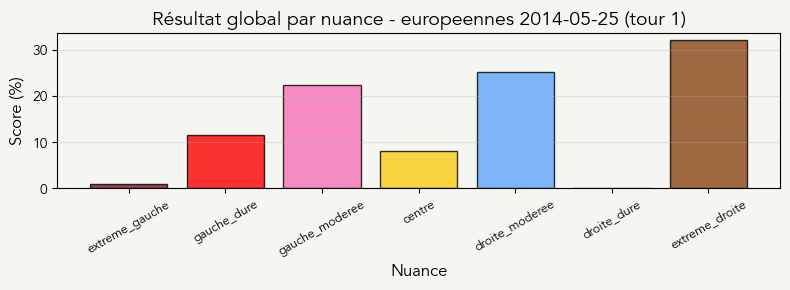

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Résultat global par nuance - legislatives 2017-06-11 (tour 1).png


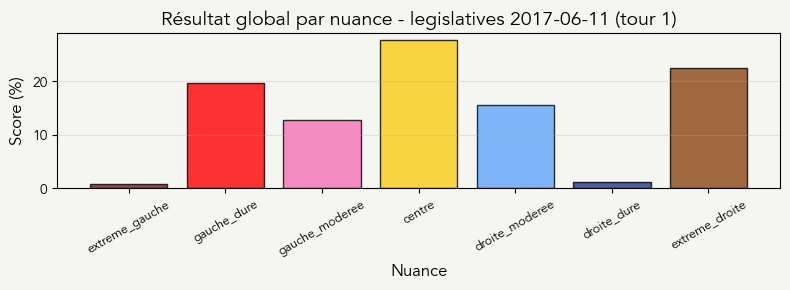

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Résultat global par nuance - legislatives 2017-06-18 (tour 2).png


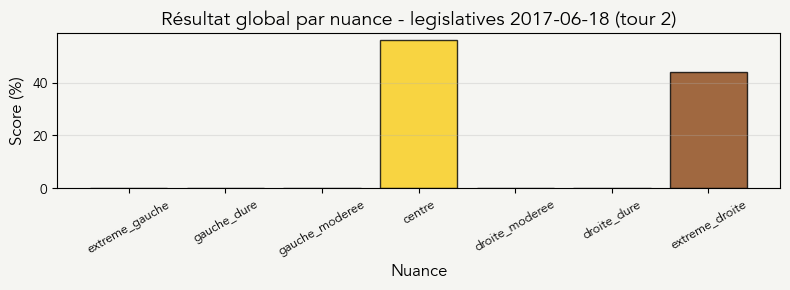

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Résultat global par nuance - municipales 2020-03-15 (tour 1).png


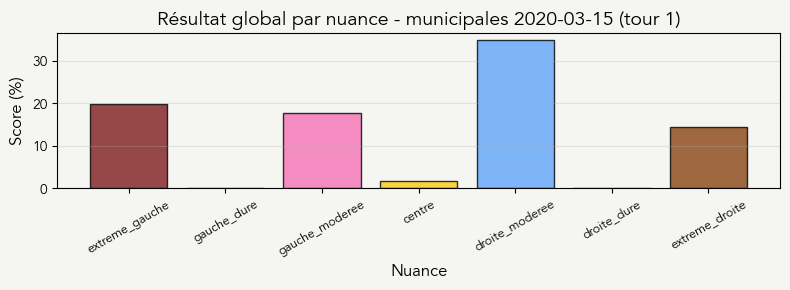

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Résultat global par nuance - municipales 2020-06-28 (tour 2).png


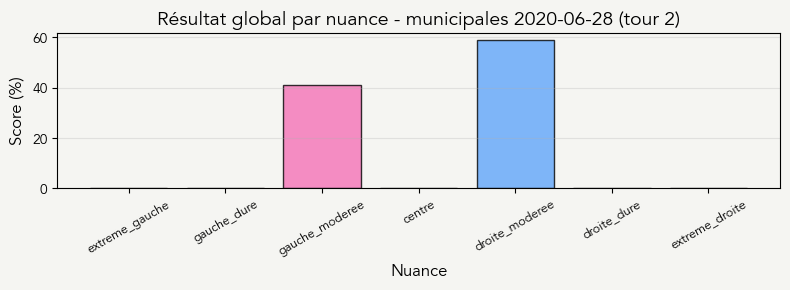

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Résultat global par nuance - departementales 2021-06-20 (tour 1).png


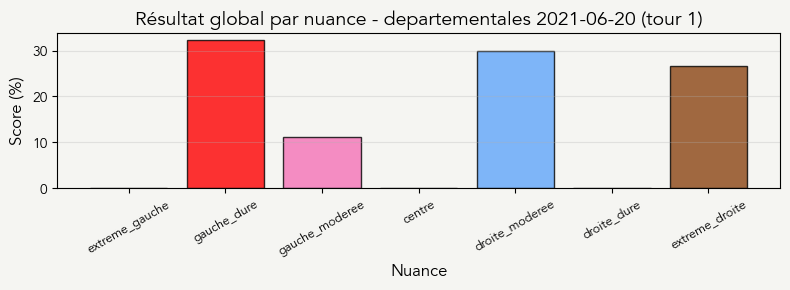

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Résultat global par nuance - regionales 2021-06-20 (tour 1).png


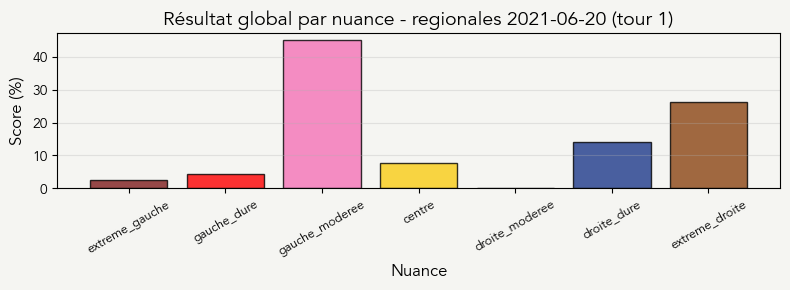

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Résultat global par nuance - departementales 2021-06-27 (tour 2).png


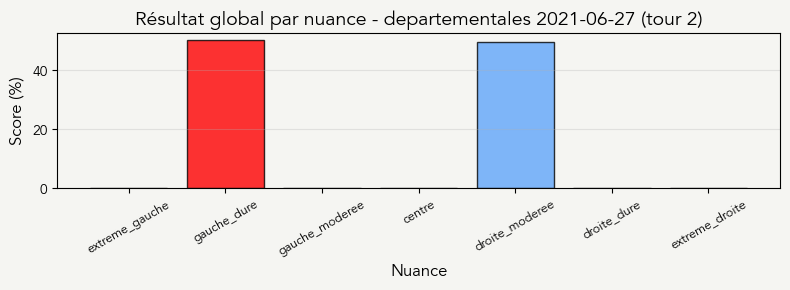

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Résultat global par nuance - regionales 2021-06-27 (tour 2).png


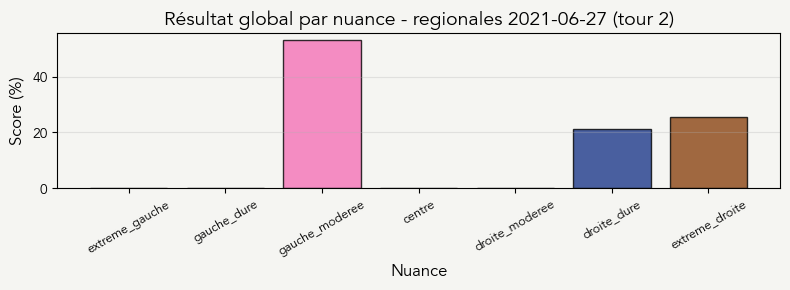

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Résultat global par nuance - legislatives 2022-06-12 (tour 1).png


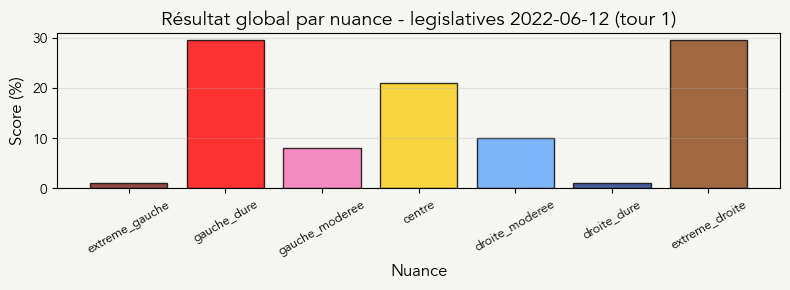

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Résultat global par nuance - legislatives 2022-06-19 (tour 2).png


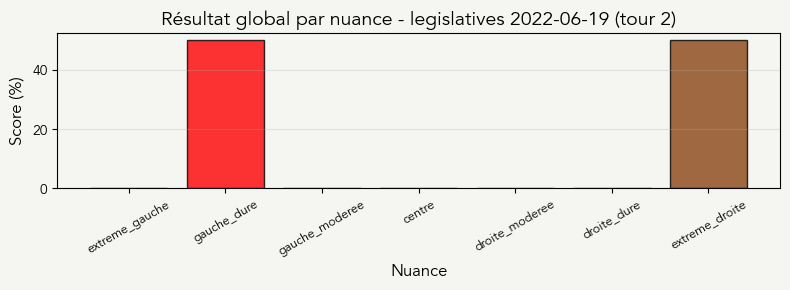

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Résultat global par nuance - europeennes 2024-06-09 (tour 1).png


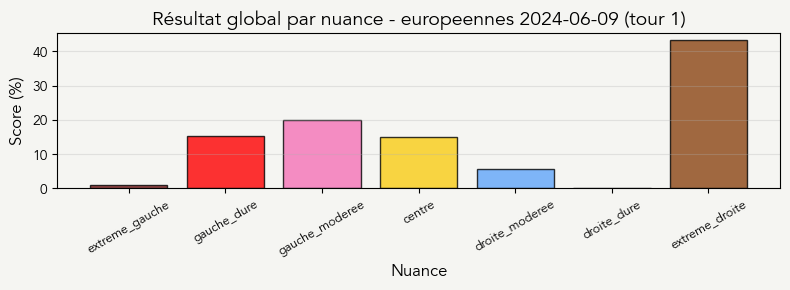

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Résultat global par nuance - legislatives 2024-06-30 (tour 1).png


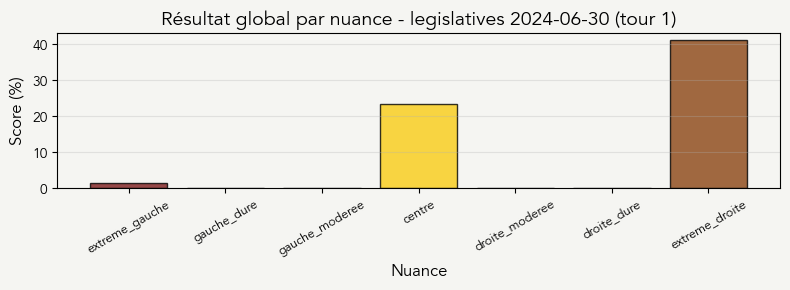

In [35]:
global_by_event = (
    nuance_series
    .groupby(["date_scrutin", "type_scrutin", "tour", "nuance"], as_index=False)
    .agg({"voix": "sum", "exprimes": "sum"})
)

global_by_event["part_exprimes"] = (
    global_by_event["voix"] / global_by_event["exprimes"].replace(0, np.nan)
)

if global_by_event.empty:
    print("Aucune donnée pour les résultats globaux par nuance.")
else:
    events = (
        global_by_event[["date_scrutin", "type_scrutin", "tour"]]
        .drop_duplicates()
        .sort_values(["date_scrutin", "type_scrutin", "tour"])
    )

    for _, event in events.iterrows():
        sub = global_by_event[
            (global_by_event["date_scrutin"] == event["date_scrutin"])
            & (global_by_event["type_scrutin"] == event["type_scrutin"])
            & (global_by_event["tour"] == event["tour"])
        ].copy()

        if sub.empty:
            continue

        pivot = (
            sub.pivot_table(index="nuance", values="part_exprimes", aggfunc="sum")
            .reindex(allowed_nuances)
            .fillna(0)
        )
        colors = [NUANCE_COLORS.get(n, COLOR_PRIMARY) for n in pivot.index]

        fig, ax = plt.subplots(figsize=(8, 3))
        ax.bar(
            pivot.index,
            pivot["part_exprimes"] * 100,
            color=colors,
            edgecolor="black",
            alpha=0.8,
        )
        event_date = event["date_scrutin"]
        if hasattr(event_date, "date"):
            event_date = event_date.date()
        ax.set_title(
            f"Résultat global par nuance - {event['type_scrutin']} {event_date} (tour {event['tour']})"
        )
        ax.set_xlabel("Nuance")
        ax.set_ylabel("Score (%)")
        ax.grid(axis="y", alpha=0.3)
        ax.tick_params(axis="x", labelrotation=30, labelsize=9)
        plt.tight_layout()
        save_fig(f"Résultat global par nuance - {event['type_scrutin']} {event_date} (tour {event['tour']})")
        plt.show()


## 8) Swing / dynamiques


In [36]:
bloc_bv = bloc_bv.sort_values(["code_bv", "type_scrutin", "tour", "bloc_1_final", "date_scrutin"])

bloc_bv["prev_part_bloc_exprimes"] = (
    bloc_bv
    .groupby(["code_bv", "type_scrutin", "tour", "bloc_1_final"])["part_bloc_exprimes"]
    .shift(1)
)
bloc_bv["swing_part_bloc"] = bloc_bv["part_bloc_exprimes"] - bloc_bv["prev_part_bloc_exprimes"]

# Decomposition participation vs preference (formule moyenne)
bloc_bv["p"] = bloc_bv["exprimes"] / bloc_bv["inscrits"].replace(0, np.nan)
bloc_bv["q"] = bloc_bv["voix"] / bloc_bv["exprimes"].replace(0, np.nan)

for v in ["p", "q"]:
    bloc_bv[f"prev_{v}"] = (
        bloc_bv
        .groupby(["code_bv", "type_scrutin", "tour", "bloc_1_final"])[v]
        .shift(1)
    )

dp = bloc_bv["p"] - bloc_bv["prev_p"]
dq = bloc_bv["q"] - bloc_bv["prev_q"]

pbar = (bloc_bv["p"] + bloc_bv["prev_p"]) / 2
qbar = (bloc_bv["q"] + bloc_bv["prev_q"]) / 2

bloc_bv["effet_participation"] = dp * qbar
bloc_bv["effet_preference"] = dq * pbar
bloc_bv["delta_score_inscrits"] = (bloc_bv["p"] * bloc_bv["q"]) - (bloc_bv["prev_p"] * bloc_bv["prev_q"])

# Top swings au niveau ville (par type)
city_swing = (
    bloc_city.sort_values(["type_scrutin", "tour", "date_scrutin"])
)
city_swing["prev_part_bloc_exprimes"] = (
    city_swing
    .groupby(["type_scrutin", "tour", "bloc_1_final"])["part_bloc_exprimes"]
    .shift(1)
)
city_swing["swing_part_bloc"] = city_swing["part_bloc_exprimes"] - city_swing["prev_part_bloc_exprimes"]

city_swing.sort_values("swing_part_bloc", ascending=False).head(10)


date_scrutin  type_scrutin  tour  annee    bloc_1_final    voix  exprimes  inscrits  part_bloc_exprimes  part_bloc_inscrits  \
59   2024-06-30  legislatives     1   2024  extreme_droite  9057.0     22058     33582            0.410599            0.269698   
53   2024-06-09   europeennes     1   2024  extreme_droite  7662.0     17719     33815            0.432417            0.226586   
47   2022-06-12  legislatives     1   2022     gauche_dure  4664.0     15833     33543            0.294575            0.139045   
51   2024-06-09   europeennes     1   2024          centre  2683.0     17719     33815            0.151419            0.079343   
45   2022-06-12  legislatives     1   2022  extreme_droite  4664.0     15833     33543            0.294575            0.139045   
49   2022-06-19  legislatives     2   2022  extreme_droite  7224.0     14460     33542            0.499585            0.215372   
55   2024-06-09   europeennes     1   2024     gauche_dure  2685.0     17719     33815            0.151532            0.079403   
58   2024-06-30  legislatives     1   2024          centre  5147.0     22058     33582            0.233339            0.153267   
60   2024-06-30  legislatives     1   2024  extreme_gauche   320.0     22058     33582            0.014507            0.009529   
46   2022-06-12  legislatives     1   2022  extreme_gauche   170.0     15347     32532            0.011077            0.005226   

    prev_part_bloc_exprimes  swing_part_bloc  
59                 0.294575         0.116025  
53                 0.320525         0.111892  
47                 0.195690         0.098885  
51                 0.080095         0.071324  
45                 0.224789         0.069786  
49                 0.440083         0.059502  
55                 0.114916         0.036616  
58                 0.208615         0.024724  
60                 0.011077         0.003430  
46                 0.008165         0.002912

## 9) Volatilite / recomposition (Pedersen)


In [37]:
# Volatilite de Pedersen = 0.5 * somme des variations absolues des parts entre deux scrutins.
bloc_bv["abs_swing_part"] = bloc_bv["swing_part_bloc"].abs()

vol_bv = (
    bloc_bv
    .groupby(["code_bv", "bureau", "date_scrutin", "type_scrutin", "tour"], as_index=False)
    ["abs_swing_part"]
    .sum()
)
vol_bv["volatilite_pedersen"] = 0.5 * vol_bv["abs_swing_part"]

vol_city = (
    city_swing
    .groupby(["date_scrutin", "type_scrutin", "tour"], as_index=False)
    .agg(volatilite_pedersen=("swing_part_bloc", lambda s: 0.5 * s.abs().sum()))
)

vol_city.sort_values("volatilite_pedersen", ascending=False).head(10)


date_scrutin     type_scrutin  tour  volatilite_pedersen
16   2024-06-09      europeennes     1             0.220080
14   2022-06-12     legislatives     1             0.171688
17   2024-06-30     legislatives     1             0.072090
15   2022-06-19     legislatives     2             0.029751
1    2017-04-23  presidentielles     1             0.000000
13   2022-04-24  presidentielles     2             0.000000
12   2022-04-10  presidentielles     1             0.000000
11   2021-06-27       regionales     2             0.000000
10   2021-06-27  departementales     2             0.000000
0    2014-05-25      europeennes     1             0.000000

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Volatilite (Pedersen) - ville.png


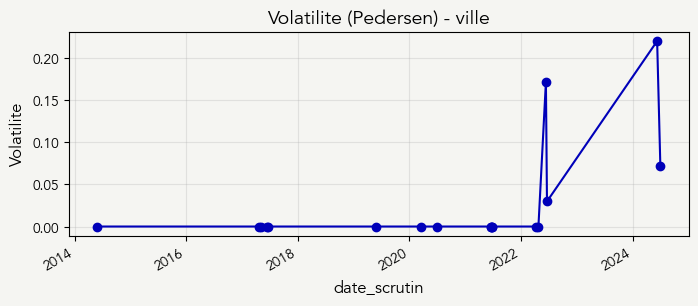

In [38]:
vol_city_sorted = vol_city.sort_values("date_scrutin")
ax = vol_city_sorted.plot(
    x="date_scrutin",
    y="volatilite_pedersen",
    marker="o",
    figsize=(8, 3),
    color=COLOR_PRIMARY,
    legend=False,
)
ax.set_title("Volatilite (Pedersen) - ville")
ax.set_ylabel("Volatilite")
ax.grid(True, alpha=0.3)
save_fig("Volatilite (Pedersen) - ville")
plt.show()


## 10) Concentration / polarisation


In [39]:
conc_bv = (
    bloc_bv
    .groupby(["code_bv", "bureau", "date_scrutin", "type_scrutin", "tour"], as_index=False)
    .agg(herfindahl=("part_bloc_exprimes", lambda s: np.nansum(s**2)))
)
conc_bv["nb_blocs_effectif"] = 1 / conc_bv["herfindahl"].replace(0, np.nan)

sorted_blocs = bloc_bv.sort_values("part_bloc_exprimes", ascending=False)

leader = (
    sorted_blocs
    .groupby(["code_bv", "date_scrutin", "type_scrutin", "tour"], as_index=False)
    .first()[["code_bv", "date_scrutin", "type_scrutin", "tour", "bloc_1_final", "part_bloc_exprimes"]]
    .rename(columns={"bloc_1_final": "bloc_leader", "part_bloc_exprimes": "part_leader"})
)

second = (
    sorted_blocs
    .groupby(["code_bv", "date_scrutin", "type_scrutin", "tour"], as_index=False)
    .nth(1)[["code_bv", "date_scrutin", "type_scrutin", "tour", "part_bloc_exprimes"]]
    .rename(columns={"part_bloc_exprimes": "part_second"})
)

polar_bv = leader.merge(second, on=["code_bv", "date_scrutin", "type_scrutin", "tour"], how="left")
polar_bv["polarisation"] = polar_bv["part_leader"] - polar_bv["part_second"]

polar_bv.sort_values("polarisation").head(10)


code_bv date_scrutin     type_scrutin  tour     bloc_leader  part_leader  part_second  polarisation
430  343010024   2024-06-09      europeennes     1     gauche_dure     0.416327     0.414286      0.002041
327  343010019   2017-06-11     legislatives     1          centre     0.270103     0.268041      0.002062
230  343010013   2022-06-12     legislatives     1  extreme_droite     0.284810     0.282700      0.002110
21   343010002   2017-06-11     legislatives     1          centre     0.248394     0.246253      0.002141
442  343010025   2021-06-27  departementales     2   droite_modere     0.501241     0.498759      0.002481
316  343010018   2021-06-27  departementales     2     gauche_dure     0.501259     0.498741      0.002519
332  343010019   2021-06-20  departementales     1     gauche_dure     0.330935     0.327338      0.003597
194  343010011   2022-06-12     legislatives     1          centre     0.274766     0.271028      0.003738
525  343010030   2017-06-11     legislatives     1          centre     0.264977     0.260369      0.004608
328  343010019   2017-06-18     legislatives     2          centre     0.502525     0.497475      0.005051

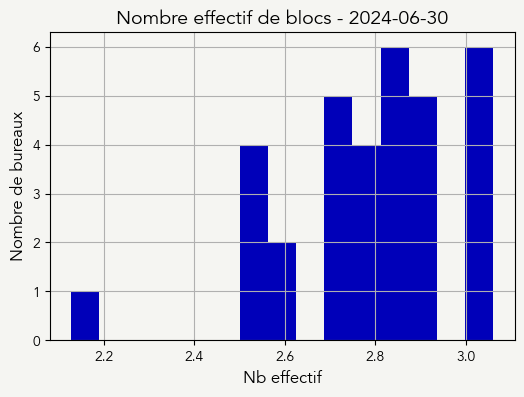

In [40]:
conc_focus = conc_bv[
    (conc_bv["type_scrutin"] == CONFIG["focus_type"])
    & (conc_bv["tour"] == CONFIG["focus_tour"])
].copy()

if not conc_focus.empty:
    latest_conc_date = conc_focus["date_scrutin"].max()
    conc_latest = conc_focus[conc_focus["date_scrutin"] == latest_conc_date]
    ax = conc_latest["nb_blocs_effectif"].dropna().hist(bins=15, figsize=(6, 4), color=COLOR_PRIMARY)
    ax.set_title(f"Nombre effectif de blocs - {latest_conc_date.date()}")
    ax.set_xlabel("Nb effectif")
    ax.set_ylabel("Nombre de bureaux")
    plt.show()


## 11) Geographie electorale (bureaux pivots & typologie)


In [41]:
FOCUS_TYPE = CONFIG["focus_type"]
FOCUS_TOUR = CONFIG["focus_tour"]


def latest_event_for_type(df: pd.DataFrame, type_scrutin: str, tour: int | None = None) -> pd.Timestamp:
    sub = df[df["type_scrutin"] == type_scrutin]
    if tour is not None:
        sub = sub[sub["tour"] == tour]
    return sub["date_scrutin"].max()


focus_year = CONFIG.get("focus_year")

focus_date = latest_event_for_type(base_bv, FOCUS_TYPE, FOCUS_TOUR)

if focus_year is not None:
    sub = base_bv[
        (base_bv["type_scrutin"] == FOCUS_TYPE)
        & (base_bv["tour"] == FOCUS_TOUR)
        & (base_bv["annee"] == focus_year)
    ]
    if sub.empty:
        raise ValueError(f"Aucun scrutin {FOCUS_TYPE} tour {FOCUS_TOUR} en {focus_year}")
    focus_date = sub["date_scrutin"].max()

focus_base = base_bv[
    (base_bv["type_scrutin"] == FOCUS_TYPE)
    & (base_bv["tour"] == FOCUS_TOUR)
    & (base_bv["date_scrutin"] == focus_date)
].copy()

focus_polar = polar_bv[
    (polar_bv["type_scrutin"] == FOCUS_TYPE)
    & (polar_bv["tour"] == FOCUS_TOUR)
    & (polar_bv["date_scrutin"] == focus_date)
].copy()

focus_vol = vol_bv[
    (vol_bv["type_scrutin"] == FOCUS_TYPE)
    & (vol_bv["tour"] == FOCUS_TOUR)
    & (vol_bv["date_scrutin"] == focus_date)
].copy()

focus = focus_base.merge(focus_polar, on=["code_bv", "date_scrutin", "type_scrutin", "tour"], how="left")
focus = focus.merge(focus_vol[["code_bv", "volatilite_pedersen"]], on="code_bv", how="left")

focus["abstention"] = 1 - focus["taux_participation"]
focus["pivot_score"] = (
    focus["polarisation"].rank(pct=True, ascending=True) * 0.5
    + focus["volatilite_pedersen"].rank(pct=True, ascending=False) * 0.5
)

print("Bureaux pivots (faible marge + forte volatilite):")
focus.sort_values("pivot_score").head(15)[
    ["code_bv", "taux_participation", "bloc_leader", "polarisation", "volatilite_pedersen"]
]


Bureaux pivots (faible marge + forte volatilite):


code_bv  taux_participation     bloc_leader  polarisation  volatilite_pedersen
12  343010013            0.512605  extreme_droite      0.002110             0.252625
29  343010030            0.461929     gauche_dure      0.011364             0.221914
6   343010007            0.519698  extreme_droite      0.032787             0.199134
30  343010031            0.505274  extreme_droite      0.084388             0.302820
19  343010020            0.487654     gauche_dure      0.021938             0.168245
14  343010015            0.521352          centre      0.018966             0.165308
9   343010010            0.505547     gauche_dure      0.074554             0.203776
10  343010011            0.520154          centre      0.003738             0.151028
13  343010014            0.492582  extreme_droite      0.037037             0.166893
8   343010009            0.465017  extreme_droite      0.062030             0.187393
11  343010012            0.527987  extreme_droite      0.056911             0.180852
2   343010003            0.482840  extreme_droite      0.012563             0.149593
4   343010005            0.479339     gauche_dure      0.182171             0.252439
0   343010001            0.476663  extreme_droite      0.066098             0.166782
7   343010008            0.585567          centre      0.105169             0.189936

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Abstention vs polarisation (focus).png


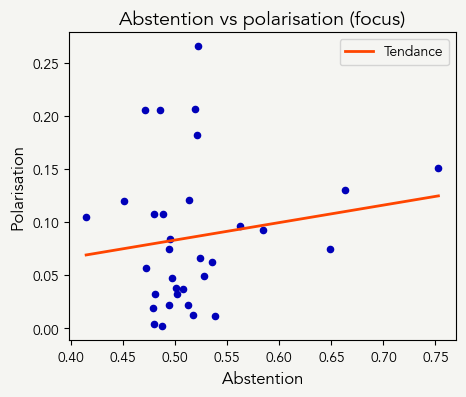

In [42]:
ax = focus.plot.scatter(x="abstention", y="polarisation", figsize=(5, 4), color=COLOR_PRIMARY)

valid = focus[["abstention", "polarisation"]].dropna()
if len(valid) >= 2:
    coef = np.polyfit(valid["abstention"], valid["polarisation"], 1)
    x_vals = np.linspace(valid["abstention"].min(), valid["abstention"].max(), 100)
    y_vals = coef[0] * x_vals + coef[1]
    ax.plot(x_vals, y_vals, color=COLOR_SECONDARY, linewidth=2, label="Tendance")
    ax.legend()

ax.set_title("Abstention vs polarisation (focus)")
ax.set_xlabel("Abstention")
ax.set_ylabel("Polarisation")
save_fig("Abstention vs polarisation (focus)")
plt.show()


In [43]:
# Typologie simple par quartiles (abstention + bloc leader)
q25, q75 = focus["abstention"].quantile([0.25, 0.75])

def classify_bureau(row: pd.Series) -> str:
    if row["abstention"] >= q75:
        abst = "forte"
    elif row["abstention"] <= q25:
        abst = "faible"
    else:
        abst = "moyenne"
    return f"abstention_{abst} + leader_{row['bloc_leader']}"

focus["typologie"] = focus.apply(classify_bureau, axis=1)
focus["typologie"].value_counts().head(10)


typologie
abstention_moyenne + leader_extreme_droite    10
abstention_forte + leader_extreme_droite       5
abstention_moyenne + leader_gauche_dure        5
abstention_faible + leader_extreme_droite      4
abstention_forte + leader_gauche_dure          4
abstention_faible + leader_centre              3
abstention_faible + leader_gauche_dure         2
Name: count, dtype: int64

## 12) Stabilite spatiale


In [44]:
# Correlations de rang (Spearman) des parts de blocs entre scrutins
bloc_pivot = (
    bloc_bv
    .pivot_table(
        index=["code_bv", "type_scrutin", "tour", "bloc_1_final"],
        columns="date_scrutin",
        values="part_bloc_exprimes",
    )
)

corrs = {}
for (type_scrutin, tour, bloc), sub in bloc_pivot.groupby(level=[1, 2, 3]):
    temp = sub.droplevel([1, 2, 3])
    corr = temp.corr(method="spearman")
    corrs[(type_scrutin, tour, bloc)] = corr

# Resume: moyenne des correlations (hors diagonale)
summary_rows = []
for (type_scrutin, tour, bloc), corr in corrs.items():
    if corr.shape[0] < 2:
        continue
    mask = ~np.eye(len(corr), dtype=bool)
    mean_corr = corr.where(mask).stack().mean()
    summary_rows.append(
        {
            "type_scrutin": type_scrutin,
            "tour": tour,
            "bloc": bloc,
            "mean_spearman": mean_corr,
        }
    )

corr_summary = pd.DataFrame(summary_rows).sort_values("mean_spearman", ascending=False)

print("Blocs les plus stables (Spearman moyen):")
print(corr_summary.head(10))

print("Blocs les moins stables (Spearman moyen):")
print(corr_summary.tail(10))

# Bureaux bascule: changement de bloc leader
leader_bv = (
    bloc_bv.sort_values("part_bloc_exprimes", ascending=False)
    .groupby(["code_bv", "type_scrutin", "tour", "date_scrutin"], as_index=False)
    .first()[["code_bv", "type_scrutin", "tour", "date_scrutin", "bloc_1_final"]]
    .rename(columns={"bloc_1_final": "bloc_leader"})
    .sort_values(["code_bv", "type_scrutin", "tour", "date_scrutin"])
)

leader_bv["prev_leader"] = (
    leader_bv
    .groupby(["code_bv", "type_scrutin", "tour"])["bloc_leader"]
    .shift(1)
)

bascule = leader_bv[leader_bv["prev_leader"].notna() & (leader_bv["bloc_leader"] != leader_bv["prev_leader"])]

bascule.head(10)


Blocs les plus stables (Spearman moyen):
    type_scrutin  tour            bloc  mean_spearman
19  legislatives     1     gauche_dure       0.843548
14  legislatives     1          centre       0.838952
12   europeennes     1   gauche_modere       0.694327
11   europeennes     1     gauche_dure       0.632925
17  legislatives     1  extreme_droite       0.591720
9    europeennes     1  extreme_droite       0.544383
18  legislatives     1  extreme_gauche       0.456698
16  legislatives     1   droite_modere       0.413953
7    europeennes     1          centre       0.356174
8    europeennes     1   droite_modere       0.335706
Blocs les moins stables (Spearman moyen):
       type_scrutin  tour            bloc  mean_spearman
32  presidentielles     2           autre            NaN
33       regionales     1          centre            NaN
34       regionales     1     droite_dure            NaN
35       regionales     1  extreme_droite            NaN
36       regionales     1  extreme_gau

code_bv  type_scrutin  tour date_scrutin     bloc_leader     prev_leader
3   343010001   europeennes     1   2019-05-26           autre  extreme_droite
4   343010001   europeennes     1   2024-06-09  extreme_droite           autre
6   343010001  legislatives     1   2022-06-12  extreme_droite          centre
9   343010001  legislatives     2   2022-06-19  extreme_droite          centre
21  343010002   europeennes     1   2019-05-26           autre  extreme_droite
22  343010002   europeennes     1   2024-06-09   gauche_modere           autre
24  343010002  legislatives     1   2022-06-12     gauche_dure          centre
25  343010002  legislatives     1   2024-06-30           autre     gauche_dure
27  343010002  legislatives     2   2022-06-19     gauche_dure          centre
39  343010003   europeennes     1   2019-05-26           autre  extreme_droite

## 13) Scenarios 2026 (municipales) - participation & recomposition


In [45]:
BASE_TYPE = CONFIG["base_type"]
BASE_TOUR = CONFIG["base_tour"]
base_date = latest_event_for_type(base_bv, BASE_TYPE, BASE_TOUR)

base_bloc = bloc_bv[
    (bloc_bv["type_scrutin"] == BASE_TYPE)
    & (bloc_bv["tour"] == BASE_TOUR)
    & (bloc_bv["date_scrutin"] == base_date)
].copy()

base_totals = base_bv[
    (base_bv["type_scrutin"] == BASE_TYPE)
    & (base_bv["tour"] == BASE_TOUR)
    & (base_bv["date_scrutin"] == base_date)
][["code_bv", "inscrits", "votants", "exprimes", "blancs", "nuls"]].copy()

base_bloc = base_bloc.merge(base_totals, on="code_bv", suffixes=("", "_base"), how="left")

base_bloc["ratio_exprimes_votants"] = base_bloc["exprimes"] / base_bloc["votants"].replace(0, np.nan)

participation_scenarios = {
    "faible": 0.40,
    "median": base_totals["votants"].sum() / base_totals["inscrits"].sum(),
    "forte": 0.60,
}

scenario_results = []
for label, taux in participation_scenarios.items():
    temp = base_bloc.copy()
    temp["votants_scen"] = temp["inscrits"] * taux
    temp["exprimes_scen"] = temp["votants_scen"] * temp["ratio_exprimes_votants"]
    temp["voix_scen"] = temp["exprimes_scen"] * temp["part_bloc_exprimes"]

    agg = (
        temp
        .groupby("bloc_1_final", as_index=False)
        .agg({"voix_scen": "sum", "exprimes_scen": "sum", "inscrits": "sum"})
    )
    agg["part_exprimes"] = agg["voix_scen"] / agg["exprimes_scen"].replace(0, np.nan)
    agg["part_inscrits"] = agg["voix_scen"] / agg["inscrits"].replace(0, np.nan)
    agg["scenario"] = label
    scenario_results.append(agg)

scenario_results = pd.concat(scenario_results, ignore_index=True)
scenario_results.sort_values(["scenario", "part_exprimes"], ascending=[True, False]).head(10)


bloc_1_final    voix_scen  exprimes_scen  inscrits  part_exprimes  part_inscrits scenario
1    droite_modere  4492.179064   12876.140825     33171       0.348876       0.135425   faible
3   extreme_gauche  2564.855130   12876.140825     33171       0.199194       0.077322   faible
4    gauche_modere  2255.026803   12876.140825     33171       0.175132       0.067982   faible
2   extreme_droite  1854.207431   12876.140825     33171       0.144003       0.055898   faible
0           centre   214.188863   12876.140825     33171       0.016635       0.006457   faible
11   droite_modere  6738.268596   19314.211237     33171       0.348876       0.203137    forte
13  extreme_gauche  3847.282695   19314.211237     33171       0.199194       0.115983    forte
14   gauche_modere  3382.540204   19314.211237     33171       0.175132       0.101973    forte
12  extreme_droite  2781.311147   19314.211237     33171       0.144003       0.083848    forte
10          centre   321.283294   19314.211237     33171       0.016635       0.009686    forte

## 14) Synthese automatique


In [46]:
summary = []

# Participation la plus faible
min_part = city_event.sort_values("taux_participation").iloc[0]
summary.append(
    f"Participation la plus faible: {min_part['type_scrutin']} {min_part['date_scrutin'].date()} (tour {int(min_part['tour'])}) = {min_part['taux_participation']:.1%}"
)

# Blancs/nuls max
max_bn = city_event.sort_values("taux_blancs_nuls_votants", ascending=False).iloc[0]
summary.append(
    f"Blancs/nuls (sur votants) max: {max_bn['type_scrutin']} {max_bn['date_scrutin'].date()} = {max_bn['taux_blancs_nuls_votants']:.1%}"
)

# Volatilite max
max_vol = vol_city.sort_values("volatilite_pedersen", ascending=False).iloc[0]
summary.append(
    f"Volatilite (Pedersen) max: {max_vol['type_scrutin']} {max_vol['date_scrutin'].date()} (tour {int(max_vol['tour'])}) = {max_vol['volatilite_pedersen']:.2f}"
)

# Bureaux pivots
pivot_list = focus.sort_values("pivot_score").head(5)["code_bv"].tolist()
summary.append(f"Bureaux pivots (extrait): {', '.join(pivot_list)}")

pd.Series(summary, name="constats")


0    Participation la plus faible: regionales 2021-...
1    Blancs/nuls (sur votants) max: presidentielles...
2    Volatilite (Pedersen) max: europeennes 2024-06...
3    Bureaux pivots (extrait): 343010013, 343010030...
Name: constats, dtype: object

In [47]:
from pathlib import Path
import pandas as pd
import re
import unicodedata

raw_path = PROJECT_ROOT / "data" / "raw" / "20_MN_T1.csv"

def read_raw(path: Path) -> pd.DataFrame:
    for enc in ("utf-8", "utf-8-sig", "latin-1"):
        try:
            return pd.read_csv(path, sep=";", encoding=enc, low_memory=False)
        except UnicodeDecodeError:
            continue
    return pd.read_csv(path, sep=";", encoding="latin-1", low_memory=False)

data_20_mn_t1 = read_raw(raw_path)

def _norm(label: str) -> str:
    text = "".join(
        ch
        for ch in unicodedata.normalize("NFKD", str(label))
        if not unicodedata.combining(ch)
    )
    text = re.sub(r"[^a-z0-9]+", "", text.lower())
    return text

def _find_code_col(cols, key: str) -> str | None:
    for col in cols:
        norm = _norm(col)
        if norm.startswith("code") and key in norm:
            return col
    return None

col_dept = _find_code_col(data_20_mn_t1.columns, "departement")
col_commune = _find_code_col(data_20_mn_t1.columns, "commune")
col_bureau = _find_code_col(data_20_mn_t1.columns, "bvote") or _find_code_col(
    data_20_mn_t1.columns, "bureau"
)

if col_commune is None or col_bureau is None:
    print("Colonnes code commune/bureau introuvables.")
    print(sorted(data_20_mn_t1.columns))
else:
    def _digits(series: pd.Series, width: int) -> pd.Series:
        return (
            series.astype(str)
            .str.replace(r"\D", "", regex=True)
            .str.zfill(width)
        )

    if col_dept:
        data_20_mn_t1["code_commune"] = _digits(
            data_20_mn_t1[col_dept], 2
        ) + _digits(data_20_mn_t1[col_commune], 3)
    else:
        data_20_mn_t1["code_commune"] = _digits(data_20_mn_t1[col_commune], 5)

    data_20_mn_t1["bureau"] = _digits(data_20_mn_t1[col_bureau], 4)

    commune_code = globals().get("COMMUNE_CODE", CONFIG.get("commune_code", "34301"))
    sete = data_20_mn_t1[data_20_mn_t1["code_commune"] == commune_code].copy()

    voix_cols = [
        c for c in sete.columns if re.fullmatch(r"Voix(\.\d+)?", str(c))
    ]
    if not voix_cols:
        print("Aucune colonne Voix trouvee.")
    else:
        frames = []
        for voix_col in voix_cols:
            suffix = str(voix_col)[len("Voix"):]
            liste_col = f"Liste{suffix}" if f"Liste{suffix}" in sete.columns else None
            nom_col = f"Nom{suffix}" if f"Nom{suffix}" in sete.columns else None
            code_col = f"Code Nuance{suffix}" if f"Code Nuance{suffix}" in sete.columns else None

            temp = sete[["bureau"]].copy()
            temp["voix"] = pd.to_numeric(sete[voix_col], errors="coerce")
            if liste_col:
                temp["nom_candidature"] = sete[liste_col]
            elif nom_col:
                temp["nom_candidature"] = sete[nom_col]
            else:
                temp["nom_candidature"] = pd.NA

            if code_col:
                temp["code_candidature"] = sete[code_col]
            else:
                temp["code_candidature"] = pd.NA

            frames.append(temp)

        candidats_long = pd.concat(frames, ignore_index=True)
        candidats_long = candidats_long[
            candidats_long["voix"].notna() & (candidats_long["voix"] > 0)
        ]
        candidats_long["nom_candidature"] = (
            candidats_long["nom_candidature"].astype("string").str.strip()
        )
        candidats_long["code_candidature"] = (
            candidats_long["code_candidature"].astype("string").str.strip().str.upper()
        )

        print(
            f"Bureaux Sete (n={candidats_long['bureau'].nunique()}):",
            sorted(candidats_long["bureau"].dropna().unique()),
        )

        candidats = (
            candidats_long
            .groupby(["nom_candidature", "code_candidature"], dropna=False)["voix"]
            .sum()
            .reset_index()
            .sort_values("voix", ascending=False)
        )
        candidats.head(20)

        candidats_par_bureau = (
            candidats_long
            .dropna(subset=["nom_candidature"])
            .groupby("bureau")["nom_candidature"]
            .apply(lambda s: sorted(set(s.dropna())))
            .reset_index(name="candidats")
        )
        candidats_par_bureau["nb_candidats"] = candidats_par_bureau["candidats"].str.len()
        candidats_par_bureau = candidats_par_bureau.sort_values("bureau")

        mapping_path = PROJECT_ROOT / "data" / "mapping_candidats_blocs.csv"
        mapping = pd.read_csv(mapping_path, sep=";")
        mapping["code_candidature"] = (
            mapping["code_candidature"].astype(str).str.strip().str.upper()
        )
        for col in ["bloc_1", "bloc_2", "bloc_3"]:
            if col in mapping.columns:
                mapping[col] = mapping[col].replace(r"^\s*$", pd.NA, regex=True)

        candidats_nuances = (
            candidats_long
            .groupby(["nom_candidature", "code_candidature"], dropna=False)["voix"]
            .sum()
            .reset_index()
            .merge(mapping, how="left", on="code_candidature", suffixes=("", "_mapping"))
            .sort_values("voix", ascending=False)
        )
        candidats_nuances["bloc_principal"] = (
            candidats_nuances["bloc_1"]
            .fillna(candidats_nuances["bloc_2"])
            .fillna(candidats_nuances["bloc_3"])
            .fillna("non_mappe")
        )

        missing_codes = (
            candidats_nuances[
                candidats_nuances["bloc_principal"] == "non_mappe"
            ]["code_candidature"]
            .dropna()
            .unique()
        )
        if len(missing_codes):
            print("Codes nuances non mappes:", sorted(missing_codes))

        candidats_nuances[[
            "nom_candidature",
            "code_candidature",
            "bloc_principal",
            "bloc_1",
            "bloc_2",
            "bloc_3",
            "voix",
        ]]



Bureaux Sete (n=31): ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031']


In [48]:
candidats_par_bureau.to_csv(PROJECT_ROOT / "output" / "sete_candidats_par_bureau.csv", index=False)

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/rapport_final/Ecart bureau vs national - municipales 2020 T1 (points).png


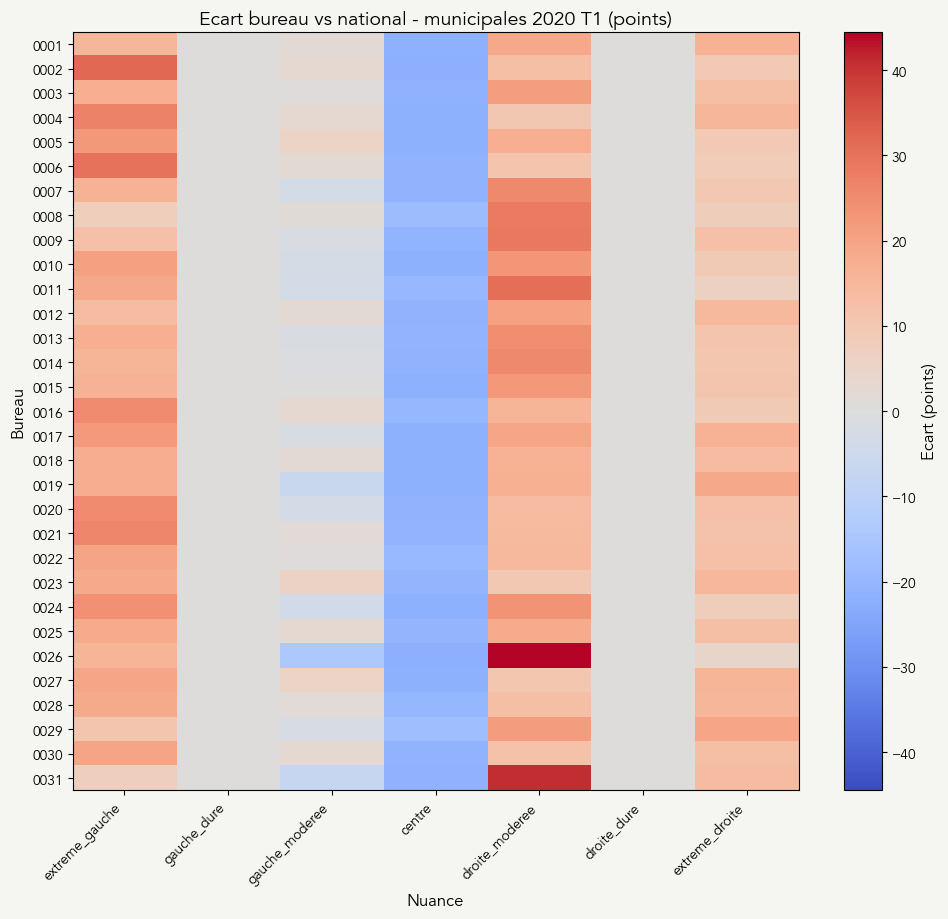

In [49]:
# Comparaison bureaux vs national (municipales 2020, tour 1)
import numpy as np

compare_type = "municipales"
compare_year = 2020
compare_tour = 1

if "mapping" not in globals():
    mapping = pd.read_csv(DATA_DIR / "mapping_candidats_blocs.csv", sep=";")
    mapping["code_candidature"] = (
        mapping["code_candidature"].astype(str).str.strip().str.upper()
    )

national_focus = elections_long.copy()
national_focus["date_scrutin"] = pd.to_datetime(national_focus["date_scrutin"], errors="coerce")
national_focus = national_focus[
    (national_focus["type_scrutin"] == compare_type)
    & (national_focus["tour"] == compare_tour)
].copy()
national_focus = national_focus[national_focus["date_scrutin"].dt.year == compare_year].copy()

if national_focus.empty:
    print(f"Aucune donnee nationale pour {compare_type} {compare_year} (tour {compare_tour}).")
else:
    focus_date = national_focus["date_scrutin"].max()
    national_focus = national_focus[national_focus["date_scrutin"] == focus_date].copy()

    base_bv_nat = (
        national_focus
        .groupby(["code_bv", "date_scrutin", "type_scrutin", "tour"], as_index=False)["exprimes"]
        .agg("first")
    )

    nat_candidates = build_candidates_long(national_focus)
    nat_candidates = nat_candidates.merge(
        mapping,
        how="left",
        left_on="code_candidature_raw",
        right_on="code_candidature",
    )

    nat_candidates["bloc_1_final"] = (
        nat_candidates["bloc_1"]
        .fillna(nat_candidates["bloc_2"])
        .fillna(nat_candidates["bloc_3"])
        .fillna("autre")
    )

    base_nuance = nat_candidates["bloc_1_final"].astype(str).str.strip().str.lower()
    nat_candidates["nuance"] = base_nuance.map(NUANCE_MAP).fillna(base_nuance)
    nat_candidates = nat_candidates[nat_candidates["nuance"].isin(ALLOWED_NUANCES)].copy()

    nat_nuance = (
        nat_candidates
        .groupby(["code_bv", "date_scrutin", "type_scrutin", "tour", "nuance"], as_index=False)
        .agg({"voix": "sum"})
    )
    nat_nuance = nat_nuance.merge(
        base_bv_nat,
        on=["code_bv", "date_scrutin", "type_scrutin", "tour"],
        how="left",
    )

    national_exprimes = base_bv_nat["exprimes"].sum()
    national_shares = (
        nat_nuance.groupby("nuance")["voix"].sum()
        / (national_exprimes if national_exprimes else np.nan)
    )
    national_shares = national_shares.reindex(ALLOWED_NUANCES).fillna(0)

    sete_focus = nuance_series[
        (nuance_series["type_scrutin"] == compare_type)
        & (nuance_series["tour"] == compare_tour)
    ].copy()
    sete_focus = sete_focus[sete_focus["date_scrutin"].dt.year == compare_year].copy()

    if sete_focus.empty:
        print(f"Aucune donnee Sete pour {compare_type} {compare_year} (tour {compare_tour}).")
    else:
        sete_date = sete_focus["date_scrutin"].max()
        sete_focus = sete_focus[sete_focus["date_scrutin"] == sete_date].copy()

        bureau_shares = (
            sete_focus
            .pivot_table(index="bureau", columns="nuance", values="part_exprimes", aggfunc="sum")
            .reindex(columns=ALLOWED_NUANCES)
            .fillna(0)
        )

        diff = (bureau_shares.subtract(national_shares, axis=1) * 100)
        diff = diff.sort_index()

        max_abs = diff.abs().to_numpy().max()
        if not np.isfinite(max_abs) or max_abs == 0:
            max_abs = 1

        fig, ax = plt.subplots(figsize=(10, max(4, 0.3 * len(diff))))
        im = ax.imshow(diff.values, aspect="auto", cmap="coolwarm", vmin=-max_abs, vmax=max_abs)
        ax.set_title("Ecart bureau vs national - municipales 2020 T1 (points)")
        ax.set_xlabel("Nuance")
        ax.set_ylabel("Bureau")
        ax.set_xticks(range(len(diff.columns)))
        ax.set_xticklabels(diff.columns, rotation=45, ha="right")
        ax.set_yticks(range(len(diff.index)))
        ax.set_yticklabels(diff.index)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Ecart (points)")
        plt.tight_layout()
        save_fig("Ecart bureau vs national - municipales 2020 T1 (points)")
        plt.show()
